In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 7 17:11:49 2024

@author: acmsavazzi
"""
#%% HARMONIE_plot.py

#%%                             Libraries
###############################################################################
import numpy as np
import pandas as pd
import xarray as xr
import os
# from xhistogram.xarray import histogram
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.ticker import MaxNLocator, FuncFormatter
from datetime import datetime, timedelta
from netCDF4 import Dataset
import matplotlib.pylab as pylab
from skimage import measure
params = {'legend.fontsize': 'large',
         'axes.labelsize': 24,
         'axes.titlesize':'large',
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'figure.figsize':[10,7],
         'figure.titlesize':24}
pylab.rcParams.update(params)
import dask
import dask.array as da
dask.config.set({"array.slicing.split_large_chunks": True})
from intake import open_catalog

In [2]:
exps     = ['HA43h22tg3_clim_noHGTQS','HA43h22tg3_clim_noHGTQS_noUVmix','HA43h22tg3_clim_noHGTQS_noSHAL'] 
# col=['k','r','g']
col = ['k','#D04848','#6895D2']
# col_obs=['#4483d5','#64bedb']
col_obs=['#F3B95F','#FDE767']
sty=['-','--',':']
lab = ['Control','UV-OFF', 'SC-OFF']

srt_time    = np.datetime64('2020-01-03T00:30')
end_time    = np.datetime64('2020-02-29T23')
# define (sub)cloud layer in km
sc_layer_base = 0 
sc_layer_top = 0.6
c_layer_base = 0.9
c_layer_top = 1.5
domain_sml  = 200            # km

my_data_dir = os.path.abspath('../data/')+'/'
figure_dir  = os.path.abspath('../figures/')+'/'

## Import data



In [3]:
# Import Observations
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")
#
joanne = cat.dropsondes.JOANNE.level3.to_dask()
joanne['alt'] = joanne['alt']/1000 # Height from m to km 
joanne = joanne.rename(name_dict={'theta':'thv'})
#
# radio_rb = cat.radiosondes.ronbrown.to_dask()
# radio_rb = radio_rb.rename(name_dict={'theta':'thv'})
# radio_mer = cat.radiosondes.ms_merian.to_dask()
# radio_mer = radio_mer.rename(name_dict={'theta':'thv'})
# radio_met = cat.radiosondes.meteor.to_dask()
# radio_met = radio_met.rename(name_dict={'theta':'thv'})
radio_bco = cat.radiosondes.bco.to_dask()
radio_bco['alt'] = radio_bco['alt']/1000 # Height from m to km 
radio_bco = radio_bco.rename(name_dict={'theta':'thv'})
#
# meteor_flx = cat.Meteor.surface_fluxes.to_dask()

### Goes
goes16_org = xr.open_mfdataset(my_data_dir+'Goes16_metrics.nc',
                           combine='by_coords',chunks={'time':-1})
goes16 = xr.open_mfdataset(my_data_dir+'Goes16_interp.nc',
                           combine='by_coords',chunks={'time':24*10})

/Users/acmsavazzi/opt/anaconda3/envs/phdproject2/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/Users/acmsavazzi/opt/anaconda3/envs/phdproject2/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [96]:
# Import experiments
harm2d = {}
harm_subsamp = {}
harm_obj = {}
harm_srf_sml = {}
harm3d_snap={}
ds_org_smoc_mean = {}
ds_org_4km = {}
harm2d_synopt = {}
harm_obj_synopt = {}
ds_org_4km_synopt={}
harm_srf_sml_synopt = {}
ds_org_smoc_mean_synopt = {}

moist_budg={}
spectral = {}
for exp in exps:
    harm2d[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_harm2d_200.nc',\
                                          combine='by_coords',chunks={'time':24*10})
    harm2d[exp]['z'] = harm2d[exp]['z']/1000  ## height in km 

    harm2d_synopt[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_harm2d_synopt.nc',\
                                          combine='by_coords',chunks={'time':24*10})
    harm2d_synopt[exp]['z'] = harm2d_synopt[exp]['z']/1000  ## height in km 

    harm_obj_synopt[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_harm_obj_synopt.nc',\
                                          combine='by_coords',chunks={'time':24*10})
    #
    ds_org_4km[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_cld_metrics_cc_4km.nc',\
                                          combine='by_coords',chunks={'time':-1})
    ds_org_4km[exp]['time']=ds_org_4km[exp].index
    ds_org_4km[exp] = ds_org_4km[exp].drop('index')
    ds_org_4km[exp] = ds_org_4km[exp].interpolate_na('time') 
    
    ds_org_4km_synopt[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_ds_org_4km_synopt.nc',\
                                          combine='by_coords',chunks={'time':24*10})

    harm_obj[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_obj_stat.nc',\
                                          combine='by_coords',chunks={'time':24*10})

    harm_srf_sml[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_harm_srf_sml.nc',\
                                          combine='by_coords',chunks={'time':24*10})
    #
    harm_srf_sml_synopt[exp] = harm_srf_sml[exp].mean(dim=('x','y')).chunk(dict(time=-1)).\
                        interpolate_na(dim='time').rolling(time=32,center=True).mean()

    # harm 3d snapshot
    harm3d_snap[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_harm3d_snapshots.nc',\
                                      combine='by_coords')


    ds_org_smoc_mean[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_smoc_metrics.nc',\
                                          combine='by_coords',chunks={'time':-1})
    ds_org_smoc_mean_synopt[exp] = ds_org_smoc_mean[exp].chunk(dict(time=-1)).interpolate_na(dim='time').rolling(time=32,center=True).mean()

    # subsampled 3d fields
    harm_subsamp[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_harm_subsamp.nc',\
                                      combine='by_coords')
    harm_subsamp[exp]['z']=harm_subsamp[exp]['z']/1000
    # moisture budget
    moist_budg[exp]=xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_moist_budg.nc', combine='by_coords')
    # spectral dataset (tke)
    spectral[exp] = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_spectral_recursive_klpInteger.nc',\
                                          combine='by_coords',chunks={'time':24*20})
    spectral[exp]['grid_spacing'] = domain_sml/(spectral[exp]['klp']*2) # km
    spectral[exp]['grid_spacing'][0] = domain_sml  ## Can not divide by klp=0, thus set first grid spacing to domain size
    spectral[exp]['z']=spectral[exp]['z']/1000



/var/folders/s5/wykd_yfn5wb9597rr8n4crdxqqfkds/T/ipykernel_59292/2755402750.py:32: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_org_4km[exp] = ds_org_4km[exp].drop('index')
/Users/acmsavazzi/opt/anaconda3/envs/phdproject2/lib/python3.11/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 240. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/var/folders/s5/wykd_yfn5wb9597rr8n4crdxqqfkds/T/ipykernel_59292/2755402750.py:32: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_org_4km[exp] = ds_org_4km[exp].drop('index')
/Users/acmsavazzi/opt/anaconda3/envs/phdproject2/lib/python3.11/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 240. This could degrade performance. Instead, consider r

In [12]:
time_CC_exp_is_larger= {}
time_CC_exp_is_smaller= {}
for exp in exps[1:]:
    time_CC_exp_is_larger[exp] = ds_org_4km_synopt[exp].where(((ds_org_4km_synopt[exp] - \
                                                         ds_org_4km_synopt['HA43h22tg3_clim_noHGTQS'])['cloud_fraction']>0).compute(),drop=True).time
    time_CC_exp_is_smaller[exp] = ds_org_4km_synopt[exp].where(((ds_org_4km_synopt[exp] - \
                                                         ds_org_4km_synopt['HA43h22tg3_clim_noHGTQS'])['cloud_fraction']<=0).compute(),drop=True).time

In [243]:
#%% Calculate cloud top from GOES16 brightness temperature
## assuming 290K at 1 km 
temp_1km = 290 # K
lapse_rate = 6 # K/km
goes16['cl_top'] = 1+(temp_1km - goes16['cl_mask'].where(goes16['cl_mask']>10))/lapse_rate


## Plotting

#### Figure 1

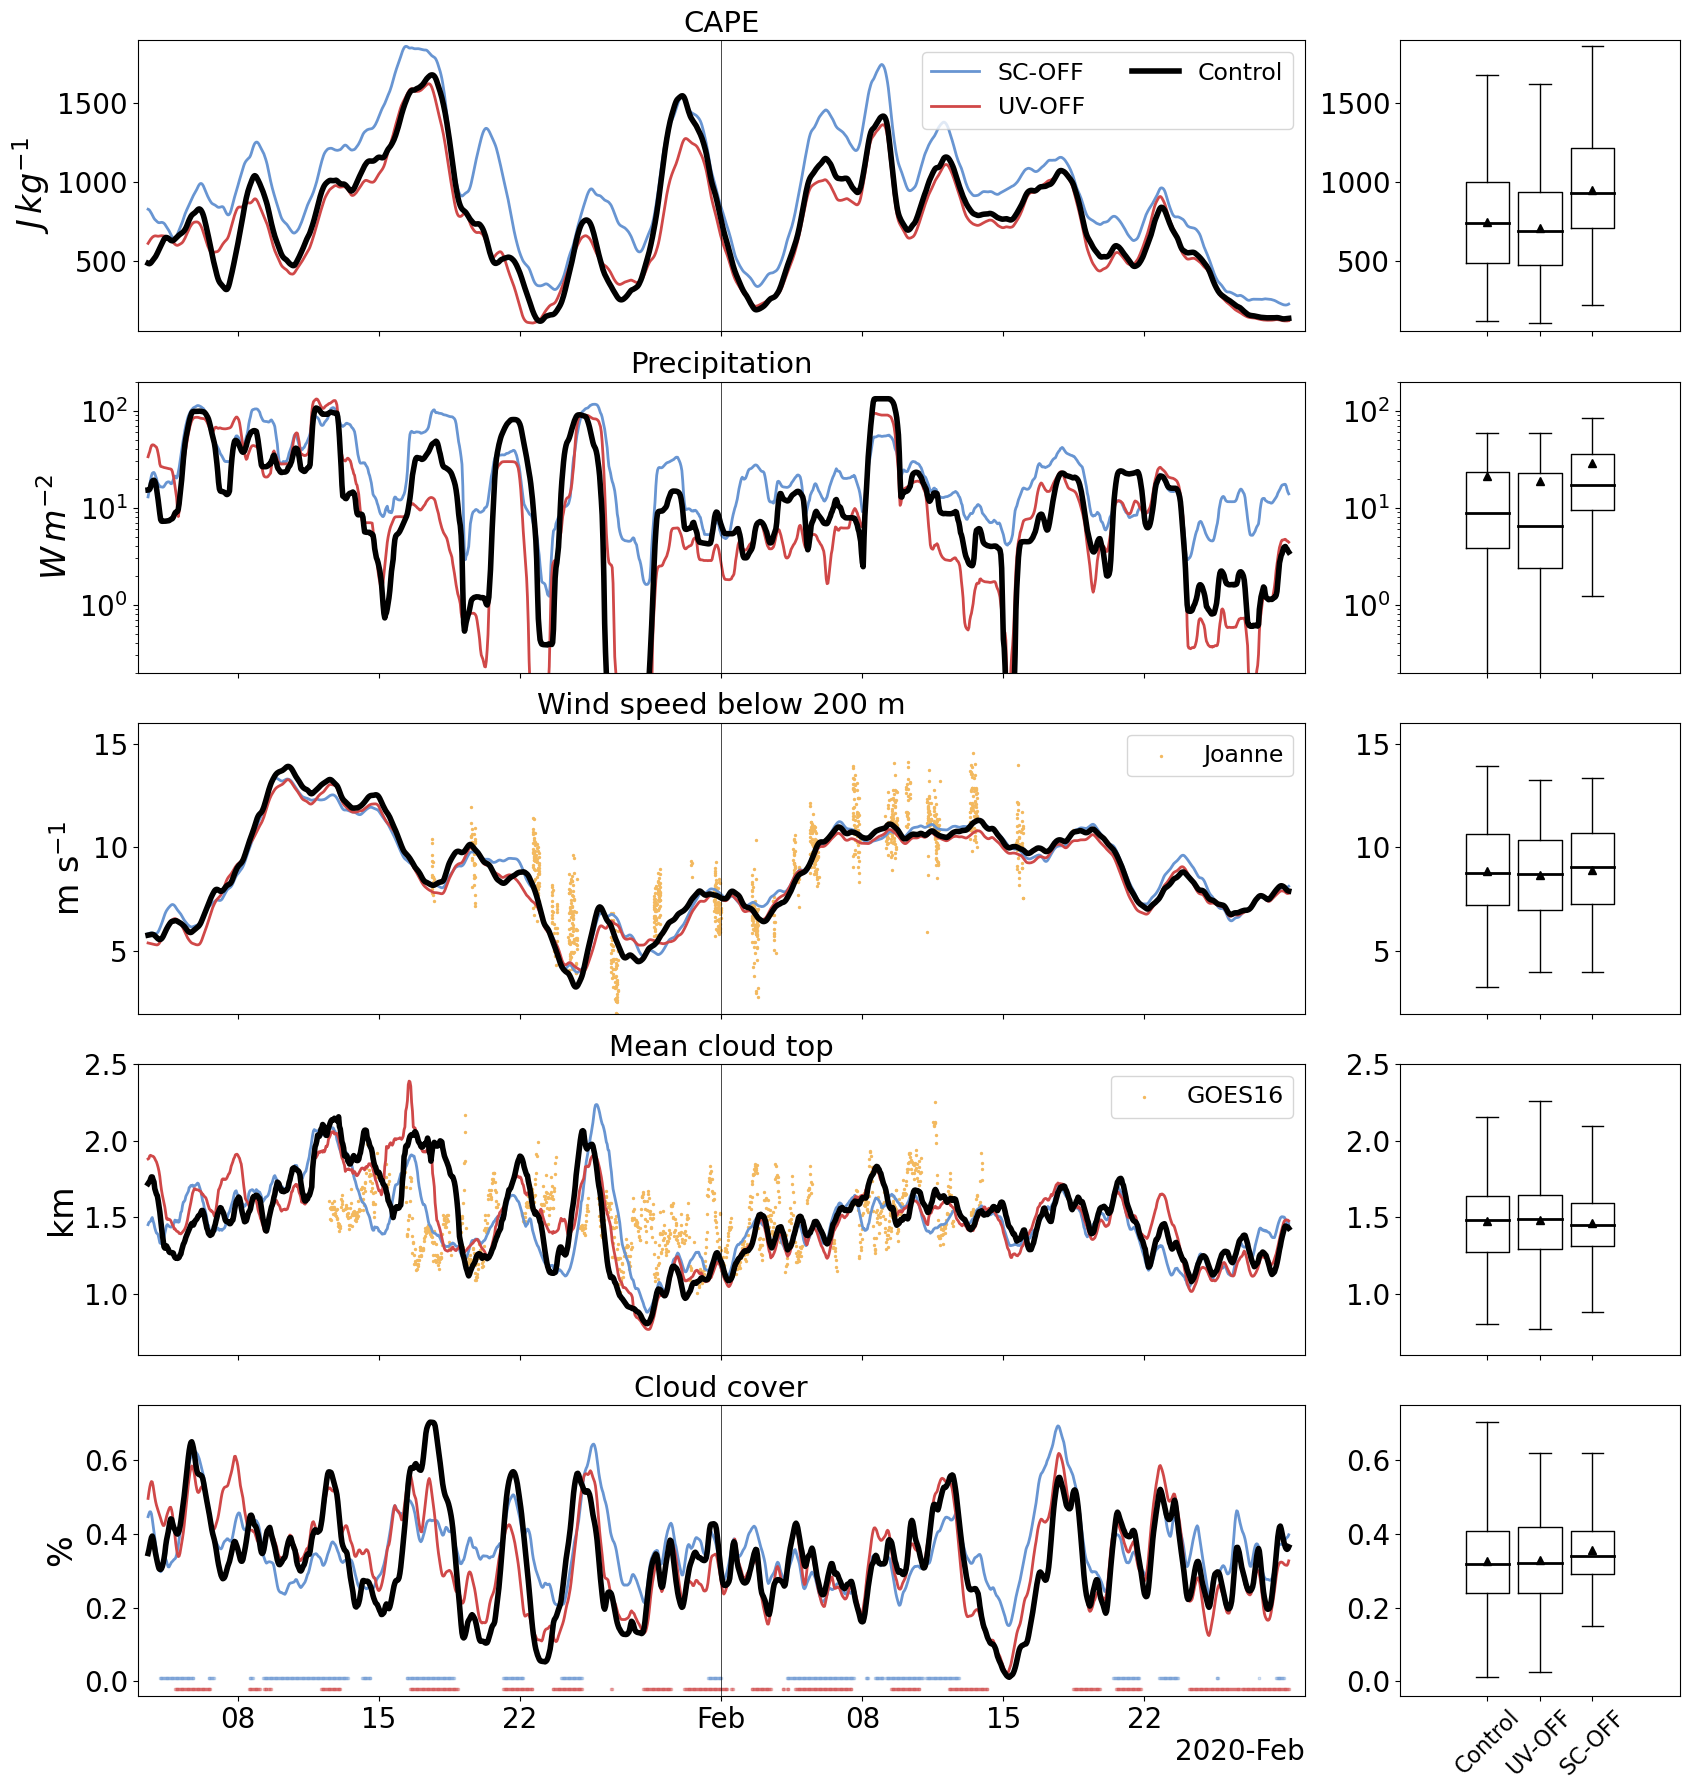

In [245]:
#%% timeseries
bottom, top = 0.1, 0.9
left, right = 0.01, 0.9
fig, axs = plt.subplots(5,2,figsize=(17,18), gridspec_kw={'width_ratios': [5,1.2]})
fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, \
                    hspace=0.15, wspace=0.1)
iteration = 1.2
labels = []
layer=[0,0.2] # up to 200m
# Observations
axs[2,0].scatter(joanne.launch_time,joanne['wspd'].sel(alt=slice(layer[0],layer[1])).mean('alt'),\
                 c=col_obs[0],s=2,label='Joanne')

axs[3,0].scatter(goes16.time,goes16['cl_top'].mean(('lat','lon')),\
                 c=col_obs[0],s=2,label='GOES16')

for ide, exp in reversed(list(enumerate(exps))):    
    if exp == exps[0]:
        line =4
    else:
        line =2
    iteration -=0.3
    label = lab[ide]  # Get the label from the 'lab' array
    labels.append(label)  # Append the label to the list
    filtered_data = {}
    for idx,var in enumerate(['cape','pr']):
        if var =='pr':
            factor = 3600 *(24/0.0346)
            title  = 'Precipitation'
            # unit   = r'$mm \, hour^{-1}$'
            unit   = r'$W \, m^{-2}$'
        elif var =='cape':
            factor = 1
            title  = 'CAPE'
            unit   = r'$J \, kg^{-1}$'

        (factor*harm_srf_sml_synopt[exp][var])\
                .plot(x='time',ls='-',ax=axs[idx,0],lw=line,c=col[ide],label=lab[ide])
        axs[idx,0].set_title(title,fontsize =21)
        axs[idx,0].set_ylabel(unit)
        ## boxplots    
        filtered_data[idx] =(factor*harm_srf_sml_synopt[exp][var])\
                    .where(~harm_srf_sml_synopt[exp].compute()[var].isnull(),drop=True).values 
    
    # HARMONIE
    harm2d_synopt[exp]['wspd'].\
        sel(z=slice(layer[0],layer[1])).mean('z')\
            .plot(x='time',ls='-',lw=line,c=col[ide],label=lab[ide],ax=axs[2,0])
    (harm_obj_synopt[exp]['mean_cl_top']/1000)\
            .plot(x='time',ls='-',lw=line,c=col[ide],ax=axs[3,0])
    harm2d_synopt[exp]['cc_4km']\
            .plot(x='time',ls='-',lw=line,c=col[ide],ax=axs[4,0])

    ## boxplots
    filtered_data[2] = harm2d_synopt[exp]['wspd']\
            .where(~harm2d_synopt[exp]['wspd'].isnull().compute(),drop=True)\
            .sel(z=slice(layer[0],layer[1])).mean('z').values
    filtered_data[3] = (harm_obj_synopt[exp]['mean_cl_top']/1000)\
            .where(~harm_obj_synopt[exp]['mean_cl_top'].isnull().compute(),drop=True).values
    filtered_data[4] = harm2d_synopt[exp]['cc_4km']\
            .where(~harm2d_synopt[exp]['cc_4km'].isnull().compute(),drop=True).values

    for idx, data in enumerate(filtered_data):
        axs[idx,1].boxplot(filtered_data[idx],\
                    positions=[round(iteration,1)],\
            whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.25,\
                medianprops=dict(color="k", lw=2),\
                meanprops={"markerfacecolor":"black",'markeredgecolor':'black'})  

    if exp==exps[1]:
        for ii in time_CC_exp_is_smaller[exp].values:
            axs[4,0].plot(ii,-0.02,marker='s', linestyle='None',\
                                               markersize=1.5,mfc='none', mec=col[ide],alpha=0.4)
    elif exp==exps[2]:
        for ii in time_CC_exp_is_smaller[exp].values:
            axs[4,0].plot(ii,0.01,marker='s', linestyle='None',\
                                               markersize=1.5,mfc='none', mec=col[ide],alpha=0.4)
for idx,var in enumerate(axs): 
    axs[idx,0].axvline(np.datetime64('2020-02-01T00'), color='k', linestyle='-', linewidth=0.5)
    axs[idx,0].set_xlim((srt_time,end_time))
    axs[idx,0].set_xlabel(r'')
    axs[idx,1].set_xlabel(r'')
    axs[idx,1].set_ylabel('')
    if idx<4:
        axs[idx,0].tick_params(labelbottom=False) 
        axs[idx,1].tick_params(labelbottom=False) 

axs[4,1].set_xticklabels(labels, rotation=45 )
axs[4,1].tick_params(axis='x', which='major', labelsize=16)

axs[2,0].set_title(r'Wind speed below 200 m',fontsize =21)
axs[2,0].set_ylabel(r'm s$^{-1}$')
axs[3,0].set_title(r'Mean cloud top',fontsize =21)
axs[3,0].set_ylabel(r'km')
axs[4,0].set_title(r'Cloud cover',fontsize =21)
axs[4,0].set_ylabel(r'%')
axs[2,0].legend(['Joanne',],fontsize=17,ncol=2)
axs[3,0].legend(['GOES16',],fontsize=17,ncol=2)
axs[0,0].legend(fontsize=17,ncol=2)
for idy in [0,1]:
    axs[0,idy].set_ylim([50,1900])
    axs[1,idy].set_ylim([0.2,200])
    axs[1,idy].set_yscale('log')
    axs[2,idy].set_ylim([2,16])
    axs[3,idy].set_ylim([0.6,2.5])
    axs[4,idy].set_ylim([-0.04,0.75])
plt.tight_layout()
plt.savefig(figure_dir+'tmser.pdf')

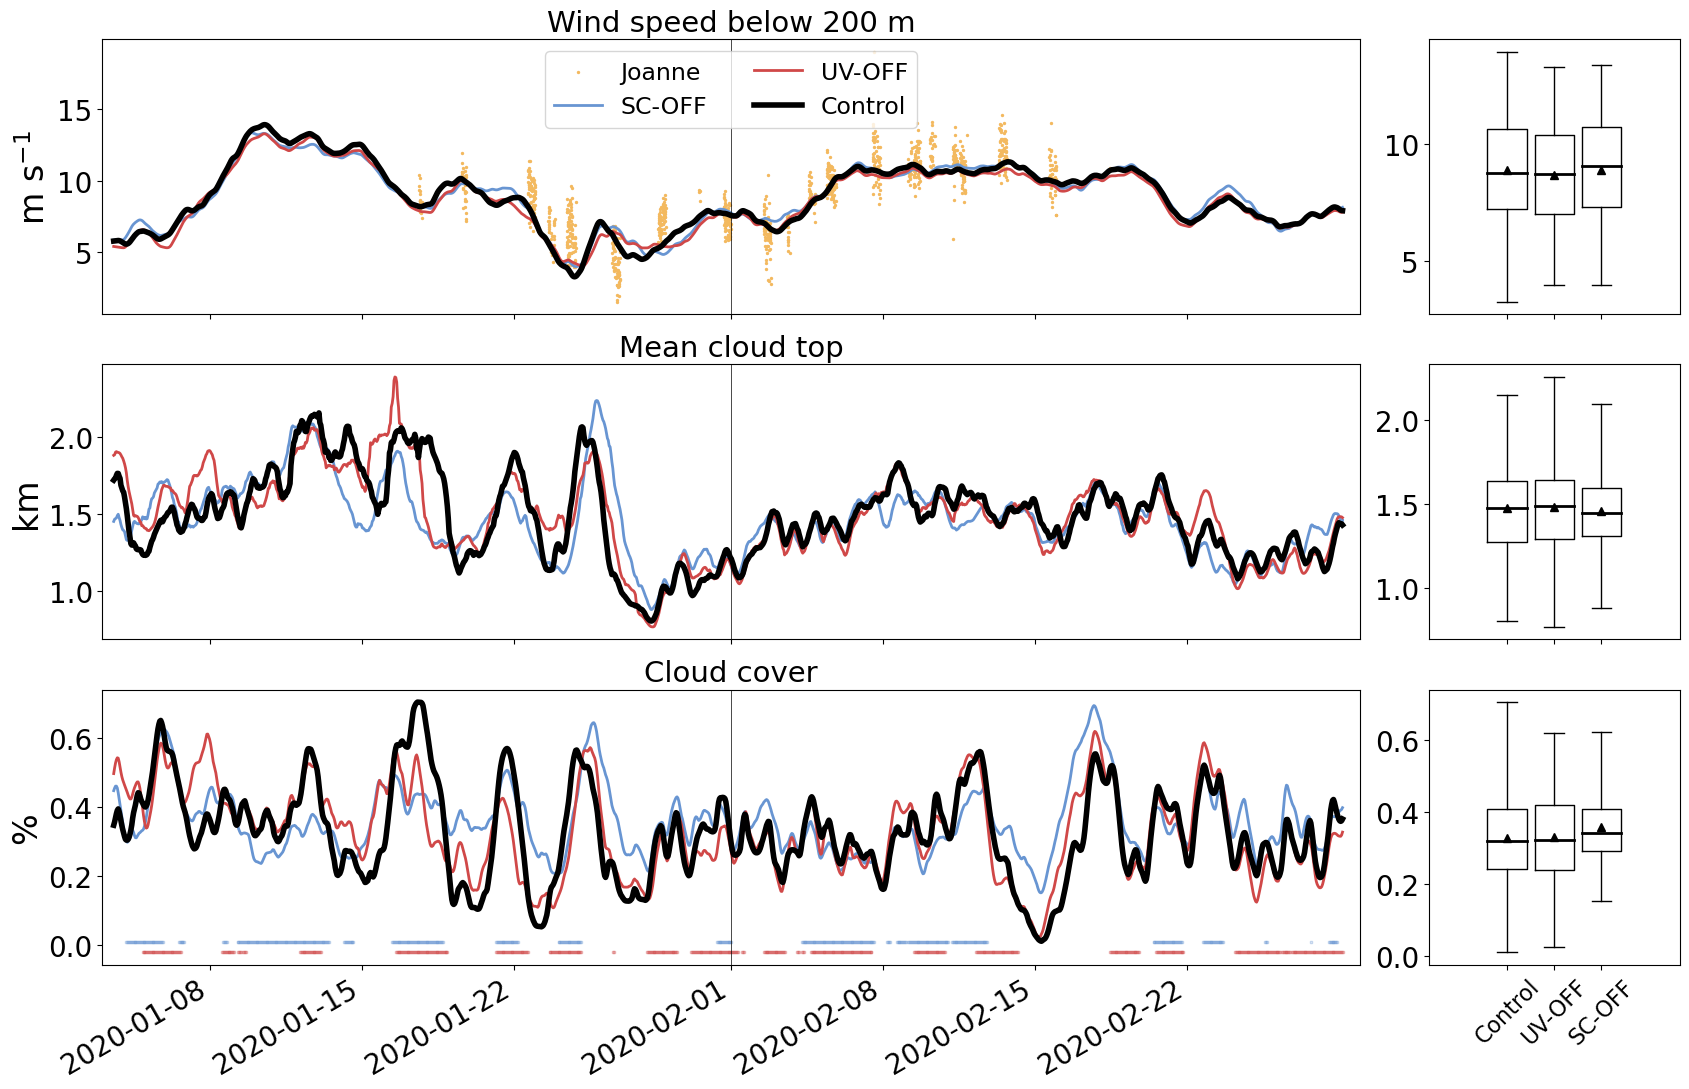

In [7]:
#%% Surface winds and clouds
bottom, top = 0.1, 0.9
left, right = 0.01, 0.9
fig, axs = plt.subplots(3,2,figsize=(17,11), gridspec_kw={'width_ratios': [5,1]})
fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, \
                    hspace=0.15, wspace=0.1)
iteration = 1.2
labels = []
layer=[0,0.2] # up to 200m
# Observations
axs[0,0].scatter(joanne.launch_time,joanne['wspd'].sel(alt=slice(layer[0],layer[1])).mean('alt'),\
                 c=col_obs[0],s=2,label='Joanne')

for ide, exp in reversed(list(enumerate(exps))):
    
    if exp == exps[0]:
        line =4
    else:
        line =2
    iteration -=0.3
    label = lab[ide]  # Get the label from the 'lab' array
    labels.append(label)  # Append the label to the list
    # HARMONIE
    harm2d_synopt[exp]['wspd'].\
        sel(z=slice(layer[0],layer[1])).mean('z')\
            .plot(x='time',ls='-',lw=line,c=col[ide],label=lab[ide],ax=axs[0,0])
    (harm_obj_synopt[exp]['mean_cl_top']/1000)\
            .plot(x='time',ls='-',lw=line,c=col[ide],ax=axs[1,0])
    harm2d_synopt[exp]['cc_4km']\
            .plot(x='time',ls='-',lw=line,c=col[ide],ax=axs[2,0])

    ## boxplots    
    filtered_data = {}
    filtered_data[0] = harm2d_synopt[exp]['wspd']\
            .where(~harm2d_synopt[exp]['wspd'].isnull().compute(),drop=True)\
            .sel(z=slice(layer[0],layer[1])).mean('z').values
    filtered_data[1] = (harm_obj_synopt[exp]['mean_cl_top']/1000)\
            .where(~harm_obj_synopt[exp]['mean_cl_top'].isnull().compute(),drop=True).values
    filtered_data[2] = harm2d_synopt[exp]['cc_4km']\
            .where(~harm2d_synopt[exp]['cc_4km'].isnull().compute(),drop=True).values

    for idx, data in enumerate(filtered_data):
        axs[idx,1].boxplot(filtered_data[idx],\
                    positions=[round(iteration,1)],\
            whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.25,\
                medianprops=dict(color="k", lw=2),\
                meanprops={"markerfacecolor":"black",'markeredgecolor':'black'})  


    if exp==exps[1]:
        for ii in time_CC_exp_is_smaller[exp].values:
            axs[2,0].plot(ii,-0.02,marker='s', linestyle='None',\
                                               markersize=1.5,mfc='none', mec=col[ide],alpha=0.4)
    elif exp==exps[2]:
        for ii in time_CC_exp_is_smaller[exp].values:
            axs[2,0].plot(ii,0.01,marker='s', linestyle='None',\
                                               markersize=1.5,mfc='none', mec=col[ide],alpha=0.4)

axs[idx,1].set_xticklabels(labels, rotation=45 )
axs[idx,1].tick_params(axis='x', which='major', labelsize=16)
axs[idx,1].set_ylabel('')
for idx,var in enumerate(axs): 
    axs[idx,0].axvline(np.datetime64('2020-02-01T00'), color='k', linestyle='-', linewidth=0.5)
    axs[idx,0].set_xlim((srt_time,end_time))
    axs[idx,0].set_xlabel(r'')
    axs[idx,1].set_xlabel(r'')

axs[0,0].set_title(r'Wind speed below 200 m',fontsize =21)
axs[0,0].set_ylabel(r'm s$^{-1}$')
axs[1,0].set_title(r'Mean cloud top',fontsize =21)
axs[1,0].set_ylabel(r'km')
axs[2,0].set_title(r'Cloud cover',fontsize =21)
axs[2,0].set_ylabel(r'%')
axs[0,0].tick_params(labelbottom=False) 
axs[1,0].tick_params(labelbottom=False) 
axs[0,1].tick_params(labelbottom=False) 
axs[1,1].tick_params(labelbottom=False) 
axs[0,0].legend(fontsize=17,ncol=2)
plt.tight_layout()
plt.savefig(figure_dir+'tmser_wspd.pdf')

#### Figure 2

In [8]:
#%% Surface fluxes and precipitation 
bottom, top = 0.1, 0.9
left, right = 0.01, 0.9
fig, axs = plt.subplots(2,3,figsize=(22,11), gridspec_kw={'width_ratios': [4,1,1]})
fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, \
                    hspace=0.15, wspace=0.1)
iteration = 1.2
labels = []
for ide, exp in reversed(list(enumerate(exps))):
    if exp == exps[0]:
        line =4
    else:
        line =2
    iteration -=0.3
    label = lab[ide]  # Get the label from the 'lab' array
    labels.append(label)  # Append the label to the list
    for idx,var in enumerate(['cape','pr']):
        if var =='pr':
            factor = 3600 *(24/0.0346)
            title  = 'Precipitation'
            # unit   = r'$mm \, hour^{-1}$'
            unit   = r'$W \, m^{-2}$'
        elif var =='cape':
            factor = 1
            title  = 'CAPE'
            unit   = r'$J \, kg^{-1}$'

        (factor*harm_srf_sml_synopt[exp][var])\
                .plot(x='time',ls='-',ax=axs[idx,0],lw=line,c=col[ide],label=lab[ide])
        axs[idx,0].set_title(title,fontsize =28)
        axs[idx,0].set_ylabel(unit)
    ## boxplots    
        if exp != exps[2]:
            for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                filtered_data =(factor*harm_srf_sml_synopt[exp][var]).sel(time=group[exps[1]])\
                .where(~harm_srf_sml_synopt[exp].compute()[var].isnull(),drop=True).values            
                axs[idx,1].boxplot(filtered_data,\
                            positions=[round(ide+3*idy,1)],\
                        whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,\
                        medianprops=dict(color=col[ide], lw=2),boxprops=dict(color=col[ide]),\
                        whiskerprops=dict(color=col[ide]),capprops=dict(color=col[ide]),\
                        meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide]})  
            
                axs[idx,1].tick_params(axis='x', which='major', labelsize=19)
        if exp != exps[1]:
            for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                filtered_data =(factor*harm_srf_sml_synopt[exp][var]).sel(time=group[exps[2]])\
                .where(~harm_srf_sml_synopt[exp].compute()[var].isnull(),drop=True).values                   
                axs[idx,2].boxplot(filtered_data,\
                            positions=[round(ide/2+3*idy,1)],\
                        whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,\
                        medianprops=dict(color=col[ide], lw=2),boxprops=dict(color=col[ide]),\
                        whiskerprops=dict(color=col[ide]),capprops=dict(color=col[ide]),\
                        meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide]})  
                axs[idx,2].tick_params(axis='x', which='major', labelsize=19)
        axs[idx,1].set_ylabel('')
        axs[idx,2].set_xlabel('')
        axs[idx,1].tick_params(labelbottom=False) 
        axs[idx,2].tick_params(labelbottom=False) 
        axs[idx,1].tick_params(labelleft=False) 
        axs[idx,2].tick_params(labelleft=False) 

    axs[0,0].set_xlabel('')
    axs[0,0].tick_params(labelbottom=False) 
    axs[1,0].set_xlabel('')
    # axs[1,0].tick_params(labelbottom=False) 
    # axs[idx,0].set_xlabel('time')
    axs[0,1].set_xlabel('')
    axs[1,1].set_xlabel('')
for idx,var in enumerate(axs): 
    axs[idx,0].axvline(np.datetime64('2020-02-01T00'), color='k', linestyle='-', linewidth=0.5)
    axs[idx,0].set_xlim((srt_time,end_time))
    
axs[0,0].set_ylim([50,1900])
axs[0,1].set_ylim([50,1900])
axs[0,2].set_ylim([50,1900])
axs[1,0].set_ylim([-5,140])
axs[1,1].set_ylim([-5,140])
axs[1,2].set_ylim([-5,140])
axs[0,0].legend(fontsize=19)
plt.tight_layout()
plt.savefig(figure_dir+'tmser_srf.pdf')

#### Figure 3

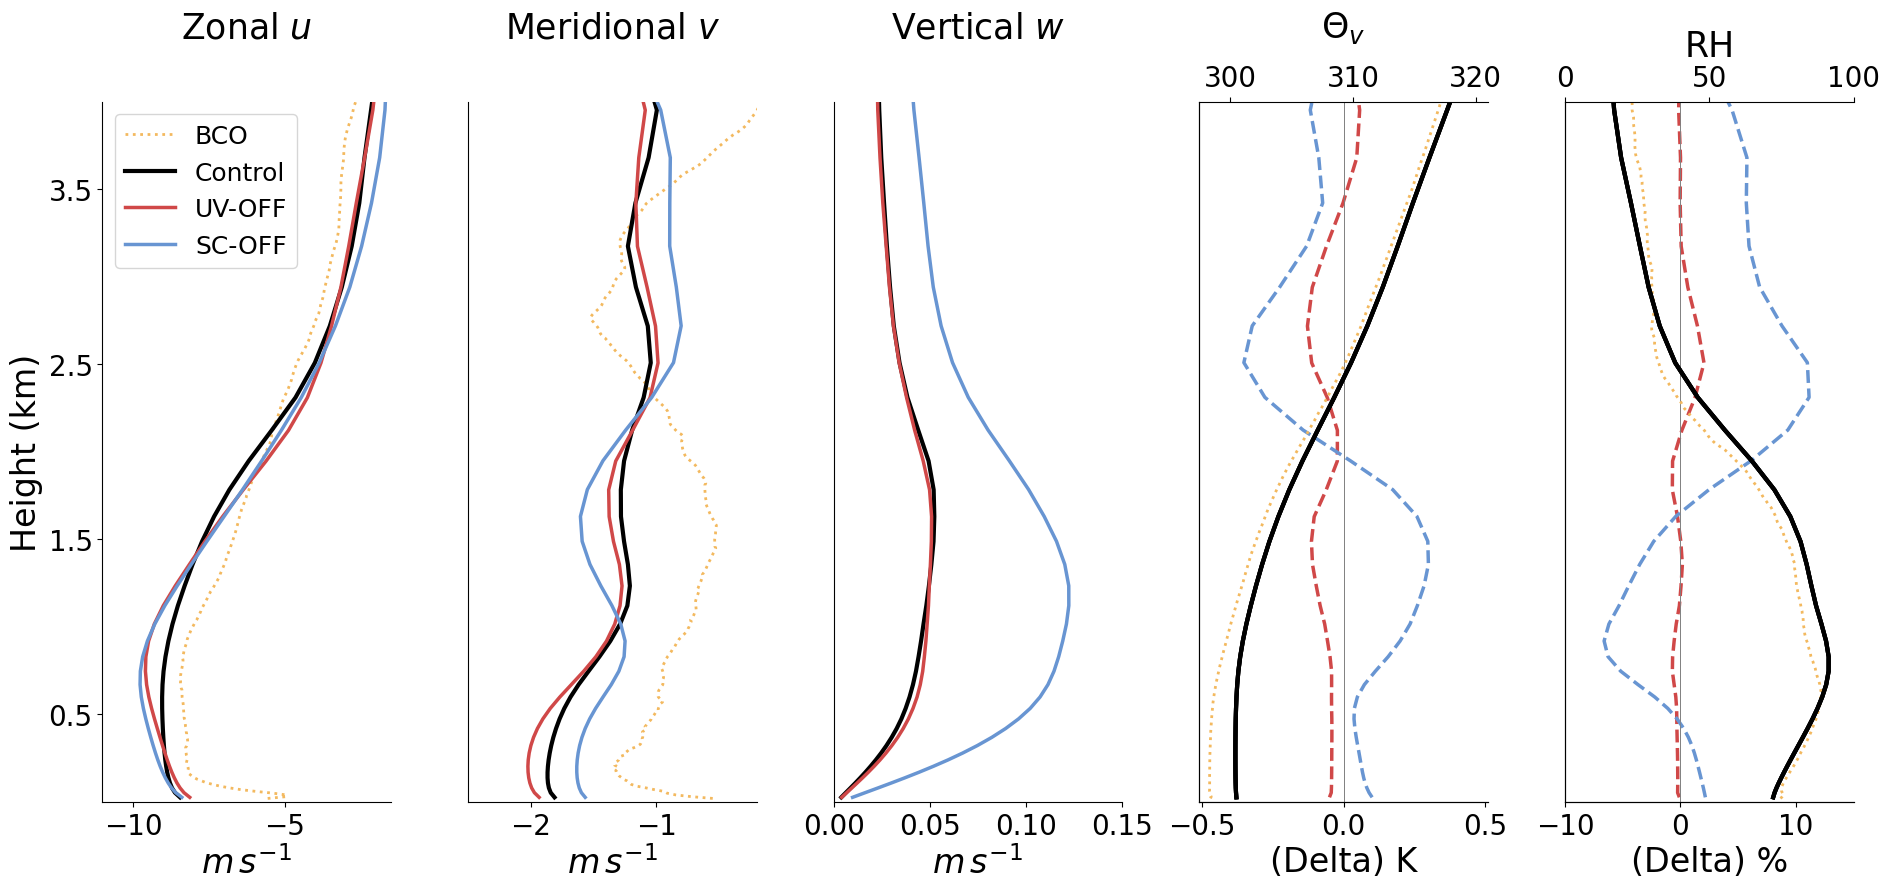

In [31]:
#%% Wind profiles mean 
layer=[0,200]
group = 'delta_cc'
fig, axs = plt.subplots(1,5,figsize=(19,9))
for idx,var in enumerate(['u','v','wa','thv','rh']):
    if var == 'thv':
        xlim_1 = [-0.51,0.51]
        xlim_2 = [297.5,321]
        # xlim_2 = [None,None]
        unit   = 'K'
        factor = 1
    elif var == 'qt':
        xlim_1 = [-0.26,0.15]
        xlim_2 = [0,1.5]
        # xlim_2 = [None,None]
        unit   = r'g kg$^{-1}$'
        factor = 100
    elif var == 'rh':
        xlim_1 = [-10,15]
        xlim_2 = [0,100]
        unit   = r'%'
        factor = 100
    else:
        xlim_1 = [None,None]
        xlim_2 = [None,None]
        unit   = None
        factor = 1

    if var in ['u','v']:
        # plot observations
        (factor*radio_bco[var]).sel(alt=slice(0.02,4)).mean('sounding').plot(
                y='alt',ax=axs[idx],ls=':',c=col_obs[0],lw=2,label='BCO')
    elif var in ['thv','qt','rh']:
        ax2 = axs[idx].twiny()
        # plot observations
        (factor*radio_bco[var]).sel(alt=slice(0.02,4)).mean('sounding').plot(
                y='alt',ax=ax2,ls=':',c=col_obs[0],lw=2)
    
    for ide, exp in enumerate(exps):
        if exp == exps[0]: lw=3
        else: lw =2.5
        cl_updraft_ctrl = harm_subsamp[exps[0]]
        cl_updraft_exp = harm_subsamp[exp]
        ds_2d_ctrl = harm2d[exps[0]]
        ds_2d_exp  = harm2d[exp]
        if (var == 'wa'):
            cl_updraft_exp[var]\
                    .mean('time').isel(z=slice(1,-1)).plot(y='z',ax=axs[idx],
                                            label=lab[ide],lw=lw,c=col[ide])
            axs[idx].set_xlabel(r'$m \, s^{-1}$')
        elif var in ['u','v']: 
            ds_2d_exp[var]\
                    .mean('time').isel(z=slice(1,-1)).plot(y='z',
                            ax=axs[idx],lw=lw,c=col[ide],label=lab[ide])

        elif var in ['thv','qt','rh']:
            ##########################
            ## first plot the control
            (ds_2d_ctrl[var]\
                .mean('time').isel(z=slice(1,-1))).plot(y='z',
                    ax=ax2,lw=3,c=col[0])
            # ax2.set_xlabel(unit)
            ax2.set_xlabel('')
            ax2.set_xlim(xlim_2)
            ax2.set_title('')
            ax2.spines['right'].set_visible(False)
            ##########################   
            ## then the 2 experimants
            if exp!= exps[0]:
                ((ds_2d_exp - ds_2d_ctrl.interp(z=ds_2d_exp.z))[var]\
                        .mean('time').isel(z=slice(1,-1))).plot(y='z',ls='--',
                                ax=axs[idx],label=lab[ide]+' - ctrl',lw=2.5,c=col[ide])   

        ##########################  
        if var in ['thv','qt','rh']:
            axs[idx].axvline(0,c='grey',lw=0.5)
            axs[idx].set_xlim(xlim_1)
        axs[idx].spines['top'].set_visible(False)
        axs[idx].spines['right'].set_visible(False)
        # axs[ide,idx].axhline(layer[0],c='grey',lw=0.3)
        # axs[ide,idx].axhline(layer[1],c='grey',lw=0.3)
        axs[idx].set_yticks([]) 
        axs[idx].set_ylabel('')
        axs[idx].set_xlabel('')
        axs[idx].set_title('')
        axs[idx].set_ylim([0,4])
        axs[0].set_xlim([-11,-1.5])
        axs[1].set_xlim([-2.5,-0.2])  
        axs[1].axvline(0,c='grey',lw=0.5)
        axs[2].set_xlim([0,0.15])  
        axs[2].axvline(0,c='grey',lw=0.5)
        axs[0].set_yticks([0.5,1.5,2.5,3.5]) 
        axs[0].set_ylabel('Height (km)')
    if var in ['thv','qt','rh']:
        axs[idx].set_xlabel('(Delta) '+unit)
    else:
        axs[idx].set_xlabel(r'$m \, s^{-1}$')
axs[0].set_title('Zonal $u$',        fontsize=25, y=1.12, pad=-14)
axs[1].set_title('Meridional $v$',   fontsize=25, y=1.12, pad=-14)
axs[2].set_title('Vertical $w$',     fontsize=25, y=1.12, pad=-14)
axs[3].set_title(r'$\Theta_v$',fontsize=25, y=1.12, pad=-14)
axs[4].set_title(r'RH',        fontsize=25)
axs[0].legend(fontsize=18)
plt.tight_layout()
plt.savefig(figure_dir+'mean_prof_rh_obs.pdf')

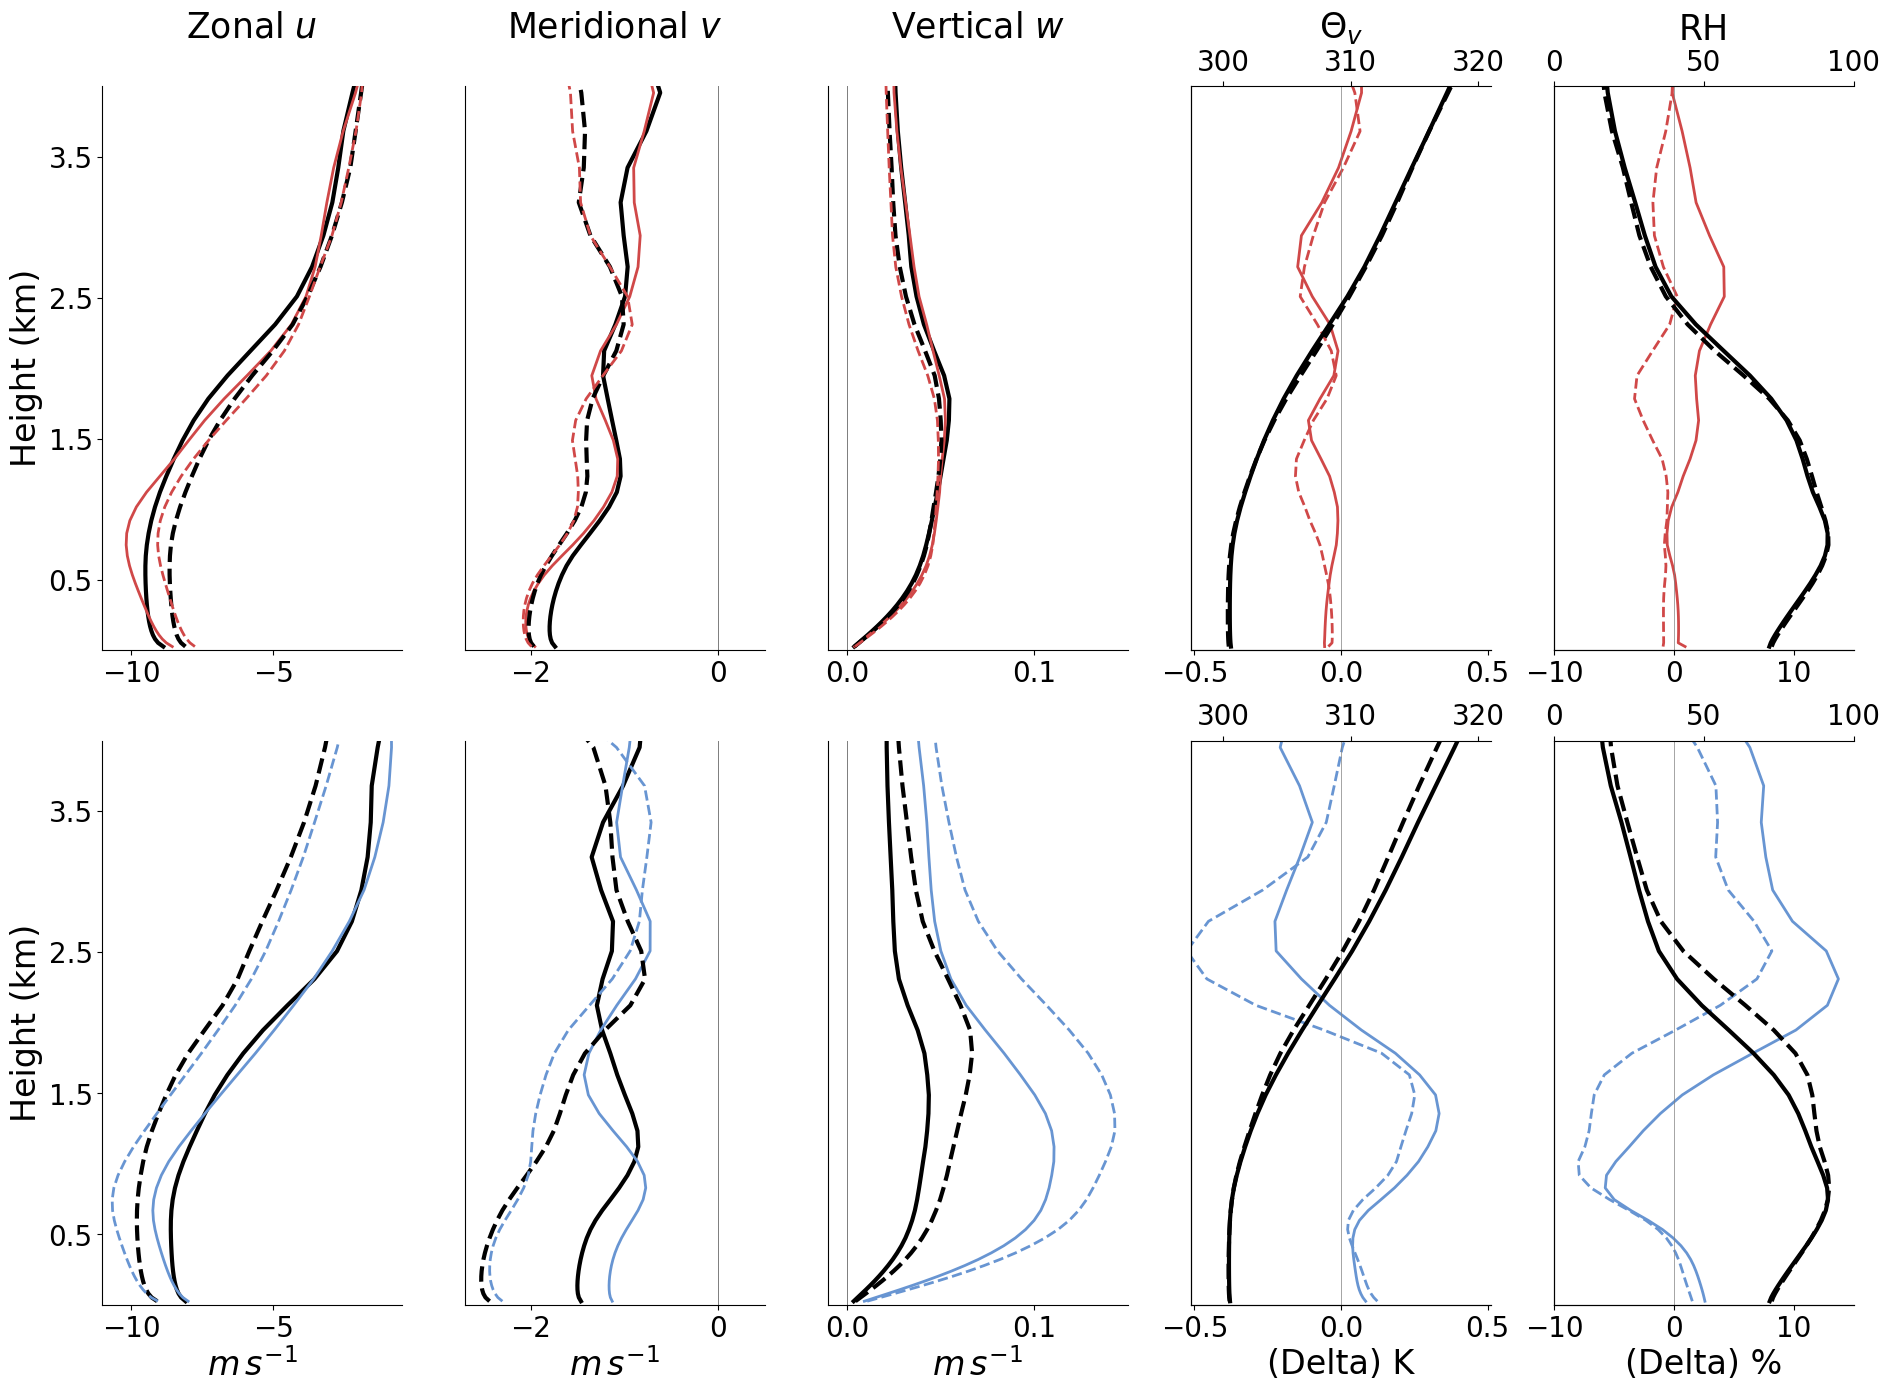

In [9]:
#%% Wind profiles by cloud cover
layer=[0,200]
group = 'delta_cc'
fig, axs = plt.subplots(2,5,figsize=(19,14))
# for idx,var in enumerate(['u','v','wa','thv','qt']):
for idx,var in enumerate(['u','v','wa','thv','rh']):
    if var == 'thv':
        xlim_1 = [-0.51,0.51]
        xlim_2 = [297.5,321]
        # xlim_2 = [None,None]
        unit   = 'K'
        factor = 1
    elif var == 'qt':
        xlim_1 = [-0.26,0.15]
        xlim_2 = [0,1.5]
        # xlim_2 = [None,None]
        unit   = r'g kg$^{-1}$'
        factor = 100
    elif var == 'rh':
        xlim_1 = [-10,15]
        xlim_2 = [0,100]
        unit   = r'%'
        factor = 100
    else:
        xlim_1 = [None,None]
        xlim_2 = [None,None]
        unit   = None
        factor = 1
    for ide, exp in enumerate(exps[1:]):
        if var in ['thv','rh']:
            ax2 = axs[ide,idx].twiny()
        for idt, time_sel in enumerate([time_CC_exp_is_larger[exp],time_CC_exp_is_smaller[exp]]):
            labels = [r'CC|'+lab[ide+1]+"\n"+'> CC|ctrl' , r'CC|'+lab[ide+1]+"\n"+'< CC|ctrl']
            cl_updraft_ctrl = harm_subsamp[exps[0]].sel(time=time_sel)
            cl_updraft_exp = harm_subsamp[exp].sel(time=time_sel)
            ds_2d_ctrl = harm2d[exps[0]].sel(time=time_sel)
            ds_2d_exp  = harm2d[exp].sel(time=time_sel)
            ##########################
            ## first plot the control
            if (var == 'wa'):
                cl_updraft_ctrl[var]\
                        .mean('time').isel(z=slice(1,-1)).plot(y='z',ax=axs[ide,idx],\
                                                label=labels[idt],lw=3,c=col[0],ls=['-','--'][idt])

            elif var in ['u','v']: 
                (factor*ds_2d_ctrl[var]\
                    .mean('time').isel(z=slice(1,-1))).plot(y='z',\
                    ls=['-','--'][idt],ax=axs[ide,idx],label=labels[idt],lw=3,c=col[0])

            elif var in ['thv','qt','rh']:
                (ds_2d_ctrl[var]\
                    .mean('time').isel(z=slice(1,-1))).plot(y='z',\
                        ls=['-','--'][idt],ax=ax2,label=labels[idt],lw=3,c=col[0])
                # ax2.set_xlabel(unit)
                ax2.set_xlabel('')
                ax2.set_xlim(xlim_2)
                ax2.set_title('')
                ax2.spines['right'].set_visible(False)
                
            ##########################   
            ## then the 2 experimants
            if (var == 'wa'):
                cl_updraft_exp[var]\
                        .mean('time').isel(z=slice(1,-1)).plot(y='z',ax=axs[ide,idx],\
                                                label=lab[ide+1],lw=2,c=col[ide+1],ls=['-','--'][idt])

                axs[ide,idx].set_xlabel(r'$m \, s^{-1}$')
            elif var in ['u','v']: 
                ds_2d_exp[var]\
                        .mean('time').isel(z=slice(1,-1)).plot(y='z',\
                                ls=['-','--'][idt],ax=axs[ide,idx],lw=2,c=col[ide+1])
            elif var in ['thv','rh']:
                ((ds_2d_exp - ds_2d_ctrl.interp(z=ds_2d_exp.z))[var]\
                        .mean('time').isel(z=slice(1,-1))).plot(y='z',\
                                ls=['-','--'][idt],ax=axs[ide,idx],label=lab[ide+1]+' - ctrl',lw=2,c=col[ide+1])       

        ##########################  
        if var in ['thv','qt','rh']:
            axs[ide,idx].axvline(0,c='grey',lw=0.5)
            axs[ide,idx].set_xlim(xlim_1)
        axs[ide,idx].spines['top'].set_visible(False)
        axs[ide,idx].spines['right'].set_visible(False)
        # axs[ide,idx].axhline(layer[0],c='grey',lw=0.3)
        # axs[ide,idx].axhline(layer[1],c='grey',lw=0.3)
        axs[ide,idx].set_yticks([]) 
        axs[ide,idx].set_ylabel('')
        axs[ide,idx].set_xlabel('')
        axs[ide,idx].set_title('')
        axs[ide,idx].set_ylim([0,4])
        axs[ide,0].set_xlim([-11,-0.5])
        axs[ide,1].set_xlim([-2.7,+0.5])  
        axs[ide,1].axvline(0,c='grey',lw=0.5)
        axs[ide,2].set_xlim([-0.01,0.15])  
        axs[ide,2].axvline(0,c='grey',lw=0.5)
        axs[ide,0].set_yticks([0.5,1.5,2.5,3.5]) 
        axs[ide,0].set_ylabel('Height (km)')
    if var in ['thv','qt','rh']:
        axs[1,idx].set_xlabel('(Delta) '+unit)
    else:
        axs[1,idx].set_xlabel(r'$m \, s^{-1}$')
axs[0,0].set_title('Zonal $u$',        fontsize=25, y=1.12, pad=-14)
axs[0,1].set_title('Meridional $v$',   fontsize=25, y=1.12, pad=-14)
axs[0,2].set_title('Vertical $w$',     fontsize=25, y=1.12, pad=-14)
axs[0,3].set_title(r'$\Theta_v$',fontsize=25, y=1.12, pad=-14)
axs[0,4].set_title(r'RH',        fontsize=25)
plt.tight_layout()
plt.savefig(figure_dir+'mean_prof_rh_byCC_noLegend.pdf')

#### Figure 4

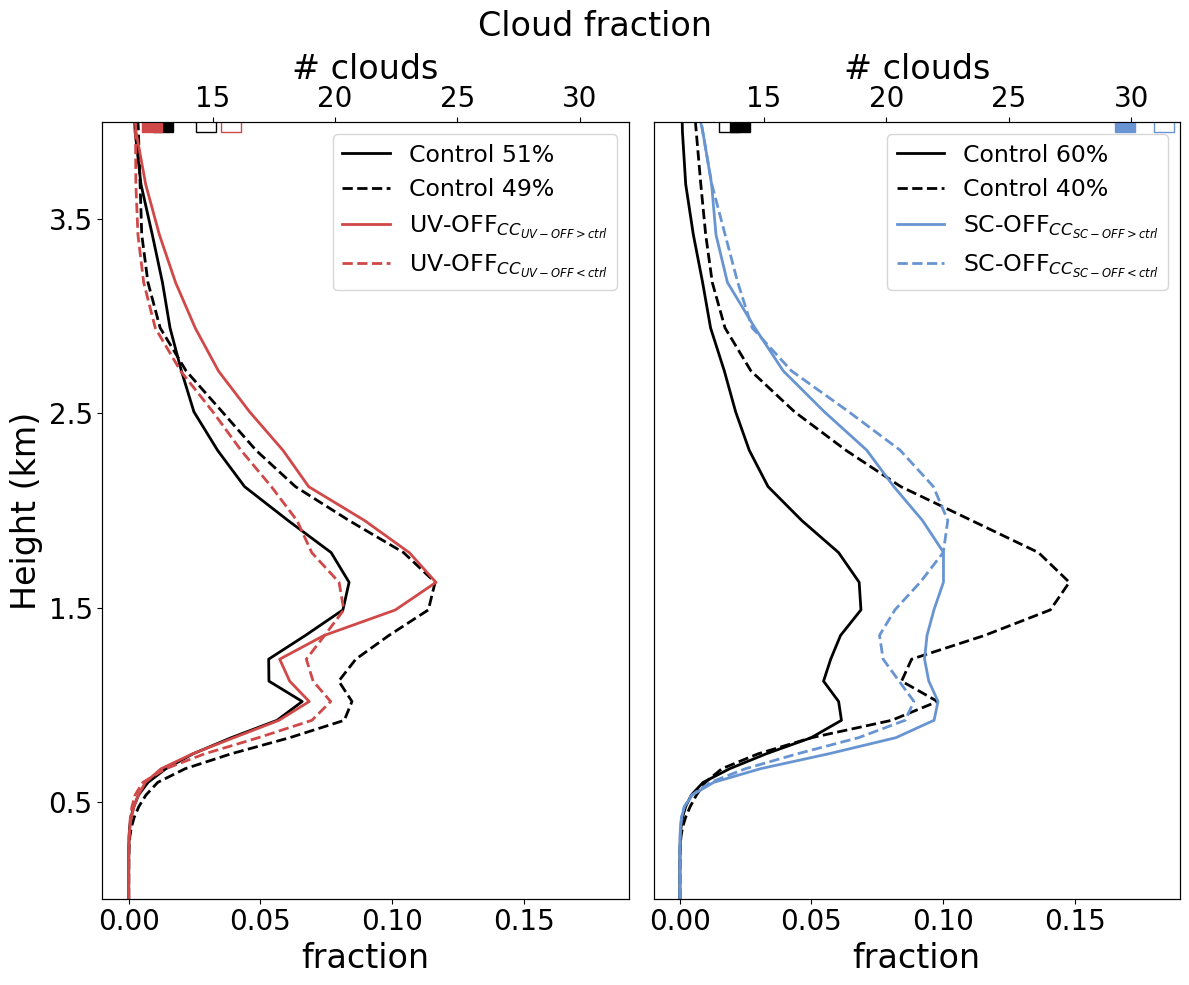

In [10]:
#%% Cloud fraction profiles by cloud cover
group = 'delta_cc'
var = 'cl'
fig, axs = plt.subplots(1,2,figsize=(12,10))

for ide, exp in enumerate(exps[1:]):
    ## first plot the control 
    harm2d[exps[0]][var].where(harm2d[exps[0]]['time'].isin(time_CC_exp_is_larger[exp])).mean('time').plot(y='z',lw=2,ls='-',\
                                                c=col[0],ax=axs[ide],\
            label=lab[0]+' '+ str(round(100*len(time_CC_exp_is_larger[exp])/(len(ds_org_4km_synopt[exp].time)-31)))+'% ')
    harm2d[exps[0]][var].where(harm2d[exps[0]]['time'].isin(time_CC_exp_is_smaller[exp])).mean('time').plot(y='z',lw=2,ls='--',\
                                                c=col[0],ax=axs[ide],\
           label=lab[0]+' '+ str(round(100*len(time_CC_exp_is_smaller[exp])/(len(ds_org_4km_synopt[exp].time)-31)))+'% ')
    
    # then the 2 experimants
    harm2d[exp][var].where(harm2d[exp]['time'].isin(time_CC_exp_is_larger[exp])).mean('time').plot(y='z',lw=2,ls='-',\
                                                c=col[ide+1],label=lab[ide+1]+r'$_{CC_{'+lab[ide+1]+'> ctrl}}$',ax=axs[ide])
    
    harm2d[exp][var].where(harm2d[exp]['time'].isin(time_CC_exp_is_smaller[exp])).mean('time').plot(y='z',lw=2,ls='--',\
                                                c=col[ide+1],label=lab[ide+1]+r'$_{CC_{'+lab[ide+1]+'< ctrl}}$',ax=axs[ide])
    ax2 = axs[ide].twiny()
    # Plot mean number of objects CC_4km
    ## first the control 
    temp1 = ds_org_4km_synopt[exps[0]]['num_objects'].sel(time=time_CC_exp_is_larger[exp]).mean('time').values
    temp2 = ds_org_4km_synopt[exps[0]]['num_objects'].sel(time=time_CC_exp_is_smaller[exp]).mean('time').values
    ax2.plot(temp1,4,marker='s', linestyle='None',\
                                       markersize=15, c=col[0])
    ax2.plot(temp2,4,marker='s', linestyle='None',\
                                       markersize=15,mfc='none', mec=col[0])
    ## then the experiments 
    temp1 = ds_org_4km_synopt[exp]['num_objects'].sel(time=time_CC_exp_is_larger[exp]).mean('time').values
    temp2 = ds_org_4km_synopt[exp]['num_objects'].sel(time=time_CC_exp_is_smaller[exp]).mean('time').values
    ax2.plot(temp1,4,marker='s', linestyle='None',\
                                       markersize=15, c=col[ide+1])
    ax2.plot(temp2,4,marker='s', linestyle='None',\
                                       markersize=15,mfc='none', mec=col[ide+1])
    
    # Customize the secondary x-axis
    ax2.set_xlabel('# clouds')
    ax2.set_xlim((10.5,32))
    axs[ide].set_ylim([0,4])
    axs[ide].set_xlim([-0.01,0.19])
    axs[ide].set_yticks([]) 
    axs[ide].set_ylabel('')
    axs[ide].set_xlabel('fraction')
    axs[ide].set_title('')
  
axs[0].set_ylabel('Height (km)')
axs[0].set_yticks([0.5,1.5,2.5,3.5]) 
axs[0].legend(fontsize=17)
axs[1].legend(fontsize=17)
plt.suptitle('Cloud fraction')
plt.tight_layout()
plt.savefig(figure_dir+'cl_frac_by_cover.pdf')

#### Cloud top distribution

#### Figure 5

In [28]:
#%% Cloud statistics + cl_top only boxplots
### ful time series 
for ds_org in [ds_org_4km_synopt,]:
    save_ext = '_4km_byCC'
    bottom, top = 0.1, 0.9
    left, right = 0.01, 0.9

    fig, axs = plt.subplots(5,2,figsize=(11,19), gridspec_kw={'width_ratios': [1,1]})
    fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, \
                        hspace=0.2, wspace=0.15)
    iteration = 0
    labels = []
    legend_handles1 = []
    legend_handles2 = []
    for ide, exp in enumerate(exps):
        iteration +=0.3
        label = lab[ide]  # Get the label from the 'lab' array
        labels.append(label)  # Append the label to the list
        for idx,var in enumerate(['num_objects','mean_length_scale','cloud_fraction','open_sky','cl_top']):
#         for idx,var in enumerate(['num_objects','mean_length_scale']):
            if var =='cloud_fraction':
                factor = 1
                title  = 'Cloud cover'
                unit   = r'fraction '
                lim =   [-0.37,0.37]
                #lim =   [-0.08,0.2]
                # (harm2d_synopt[exp]['cc_1_5to4km']-harm2d_synopt['HA43h22tg3_clim_noHGTQS']['cc_1_5to4km'])\
                #     .plot(x='time',ax=axs[idx,0],ls=':',lw=3,c=col[ide])
            elif var =='num_objects':
                factor = 1
                title  = 'Number of clouds'
                unit   = r'number #'
                lim =   [-10,50]
                # (harm_obj_synopt[exp]['num_high_obj']-harm_obj_synopt['HA43h22tg3_clim_noHGTQS']['num_high_obj'])\
                #     .plot(x='time',c=col[ide],lw=3,ls=':',ax=axs[idx,0])
            elif var =='cl_top':
                factor = 1
                title  = r'Cloud top'
                unit   = r'km'
                lim =   [0.7,5]
            elif var == 'mean_length_scale':
                factor = 1
                title  ='Mean length scale'
                unit   = r'km'
                lim =   [-20,15]
                #lim =   [-3,10]
            elif var == 'open_sky':
                factor = 1
                title  ='Open sky'
                unit   = r'fraction '
                lim =   [-0.6,0.3]
            else:
                factor = 1
                title = var

            ## boxplots
            if exp != exps[2]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    if var == 'cl_top':
                        temp_hist = (harm_obj[exp]/1000).sel(time=group[exps[1]]).mean('time')                    
                        axs[idx,0].bxp([{'label': lab[ide],
                                'mean': temp_hist['mean_cl_top'],
                                'whishi': temp_hist['max_cl_top'],
                                'whislo': temp_hist['min_cl_top'],
                                'q1': temp_hist['q1_cl_top'],
                                'med': temp_hist['q2_cl_top'],
                                'q3': temp_hist['q3_cl_top']},],
                                vert=True,
                                showfliers= False,
                                showmeans = True,
                                positions = [round(ide+3*idy,1)],
                                widths = 0.51,
                                whiskerprops = dict(linestyle=sty[idy], linewidth=2, color=col[ide]),
                                capprops = dict(linestyle=sty[idy], linewidth=2, color=col[ide]),
                                medianprops = dict(linestyle=sty[idy], linewidth=2, color=col[ide]),
                                boxprops = dict(linestyle=sty[idy], linewidth=2, color=col[ide]),
                                meanprops = {"markerfacecolor":col[ide],'markeredgecolor':col[ide]})
                    else:
                        filtered_data = ds_org[exp].sel(time=group[exps[1]])[var].where(~ds_org[exp][var].isnull().compute(), drop=True).values
                        plot1 = axs[idx,0].boxplot(filtered_data,\
                                    positions=[round(ide+3*idy,1)],whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,
                                    medianprops=dict(color=col[ide],lw=2,linestyle=sty[idy]),
                                    boxprops=dict(color=col[ide],lw=2,linestyle=sty[idy]),
                                    whiskerprops=dict(color=col[ide],lw=2,linestyle=sty[idy]),
                                    capprops=dict(color=col[ide],lw=2,linestyle=sty[idy]),
                                    meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide],"linestyle":sty[idy]},
                                    )  
                        legend_handles1.append(plot1["boxes"][0])
                    axs[idx,1].tick_params(axis='x', which='major', labelsize=19)
                    
            if exp != exps[1]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    if var == 'cl_top':
                        temp_hist = (harm_obj[exp]/1000).sel(time=group[exps[2]]).mean('time')                    
                        axs[idx,1].bxp([{'label': lab[ide],
                                'mean': temp_hist['mean_cl_top'],
                                'whishi': temp_hist['max_cl_top'],
                                'whislo': temp_hist['min_cl_top'],
                                'q1': temp_hist['q1_cl_top'],
                                'med': temp_hist['q2_cl_top'],
                                'q3': temp_hist['q3_cl_top']},],
                                vert=True,
                                showfliers= False,
                                showmeans = True,
                                positions = [round(ide/2+3*idy,1)],
                                widths = 0.51,
                                whiskerprops = dict(linestyle=sty[idy], linewidth=2, color=col[ide]),
                                capprops = dict(linestyle=sty[idy], linewidth=2, color=col[ide]),
                                medianprops = dict(linestyle=sty[idy], linewidth=2, color=col[ide]),
                                boxprops = dict(linestyle=sty[idy], linewidth=2, color=col[ide]),
                                meanprops = {"markerfacecolor":col[ide],'markeredgecolor':col[ide]})
                    else:
                        filtered_data = ds_org[exp].sel(time=group[exps[2]])[var].where(~ds_org[exp][var].isnull().compute(), drop=True).values
                        plot2 = axs[idx,1].boxplot(filtered_data,\
                                    positions=[round(ide/2+3*idy,1)],whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,
                                    medianprops=dict(color=col[ide], lw=2,linestyle=sty[idy]),
                                    boxprops=dict(color=col[ide],lw=2,linestyle=sty[idy]),
                                    whiskerprops=dict(color=col[ide],lw=2,linestyle=sty[idy]),
                                    capprops=dict(color=col[ide],lw=2,linestyle=sty[idy]),
                                    meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide],"linestyle":sty[idy]},
                                    ) 
                        legend_handles2.append(plot2["boxes"][0])
                    axs[idx,1].tick_params(axis='both', which='major',labelsize=19)

            axs[idx,0].set_title(title,fontsize =24,x=1.1)
            axs[idx,0].set_ylabel(unit,fontsize=19)
            if idx <axs.shape[0]-1:
                axs[idx,0].set_xlabel('')
                axs[idx,1].set_xlabel('')
                axs[idx,0].tick_params(labelbottom=False) 
                axs[idx,1].tick_params(labelbottom=False) 

    
    axs[axs.shape[0]-1,0].set_xticklabels([labels[0],labels[0],labels[1],labels[1]], rotation=45 )
    axs[axs.shape[0]-1,0].tick_params(axis='x', which='major', labelsize=16)
    axs[axs.shape[0]-1,1].set_xticklabels([labels[0],labels[0],labels[2],labels[2]], rotation=45 )
    axs[axs.shape[0]-1,1].tick_params(axis='x', which='major', labelsize=16)

    for idy in [0,1]:
        axs[0,idy].set_ylim([0,55])
        axs[1,idy].set_ylim([3,38])
        axs[2,idy].set_ylim([0,0.75])
        axs[3,idy].set_ylim([0,0.95])
        axs[4,idy].set_ylim([0.7,2.99])

    axs[0, 0].legend(handles=[legend_handles1[0],legend_handles1[7]],
                     labels=[r'$CC_{'+lab[1]+'}$ > $CC_{control}}$','$CC_{'+lab[1]+'}$ < $CC_{control}}$'],
                loc="upper left", fontsize=15)
    axs[0, 1].legend(handles=[legend_handles2[0],legend_handles2[7]],
                     labels=[r'$CC_{'+lab[2]+'}$ > $CC_{control}}$','$CC_{'+lab[2]+'}$ < $CC_{control}}$'],
                loc="upper left",fontsize=15)
    plt.tight_layout()
    plt.savefig(figure_dir+'bxplt_cl_metrics'+save_ext+'.pdf')

In [136]:
#%% Cloud statistics only boxplots
### ful time series 
for ds_org in [ds_org_4km_synopt,]:
    save_ext = '_4km_byCC'
    bottom, top = 0.1, 0.9
    left, right = 0.01, 0.9

    fig, axs = plt.subplots(4,2,figsize=(11,17), gridspec_kw={'width_ratios': [1,1]})
    fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, \
                        hspace=0.2, wspace=0.15)
    iteration = 0
    labels = []
    legend_handles1 = []
    legend_handles2 = []
    for ide, exp in enumerate(exps):
        iteration +=0.3
        label = lab[ide]  # Get the label from the 'lab' array
        labels.append(label)  # Append the label to the list
        for idx,var in enumerate(['num_objects','mean_length_scale','cloud_fraction','open_sky']):
#         for idx,var in enumerate(['num_objects','mean_length_scale']):
            if var =='cloud_fraction':
                factor = 1
                title  = 'Cloud cover'
                unit   = r'fraction '
                lim =   [-0.37,0.37]
                #lim =   [-0.08,0.2]
                # (harm2d_synopt[exp]['cc_1_5to4km']-harm2d_synopt['HA43h22tg3_clim_noHGTQS']['cc_1_5to4km'])\
                #     .plot(x='time',ax=axs[idx,0],ls=':',lw=3,c=col[ide])
            elif var =='num_objects':
                factor = 1
                title  = 'Number of clouds'
                unit   = r'number #'
                lim =   [-10,50]
                # (harm_obj_synopt[exp]['num_high_obj']-harm_obj_synopt['HA43h22tg3_clim_noHGTQS']['num_high_obj'])\
                #     .plot(x='time',c=col[ide],lw=3,ls=':',ax=axs[idx,0])
            elif var =='iorg':
                factor = 1
                title  = r'$I_{org}$'
                unit   = r'$I_{org}$'
            elif var == 'mean_length_scale':
                factor = 1
                title  ='Mean length scale'
                unit   = r'km'
                lim =   [-20,15]
                #lim =   [-3,10]
            elif var == 'open_sky':
                factor = 1
                title  ='Open sky'
                unit   = r'fraction '
                lim =   [-0.6,0.3]
            else:
                factor = 1
                title = var

            ## boxplots
            if exp != exps[2]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    filtered_data = ds_org[exp].sel(time=group[exps[1]])[var].where(~ds_org[exp][var].isnull().compute(), drop=True).values
                    plot1 = axs[idx,0].boxplot(filtered_data,\
                                positions=[round(ide+3*idy,1)],whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,
                                medianprops=dict(color=col[ide], lw=2,linestyle=sty[idy]),
                                boxprops=dict(color=col[ide],linestyle=sty[idy]),
                                whiskerprops=dict(color=col[ide],linestyle=sty[idy]),
                                capprops=dict(color=col[ide],linestyle=sty[idy]),
                                meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide],"linestyle":sty[idy]},
                                )  
                    legend_handles1.append(plot1["boxes"][0])
                    axs[idx,1].tick_params(axis='x', which='major', labelsize=19)
            if exp != exps[1]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    filtered_data = ds_org[exp].sel(time=group[exps[2]])[var].where(~ds_org[exp][var].isnull().compute(), drop=True).values
                    plot2 = axs[idx,1].boxplot(filtered_data,\
                                positions=[round(ide/2+3*idy,1)],whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,
                               medianprops=dict(color=col[ide], lw=2,linestyle=sty[idy]),
                                boxprops=dict(color=col[ide],linestyle=sty[idy]),
                                whiskerprops=dict(color=col[ide],linestyle=sty[idy]),
                                capprops=dict(color=col[ide],linestyle=sty[idy]),
                                meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide],"linestyle":sty[idy]},
                                ) 
                    legend_handles2.append(plot2["boxes"][0])
                    axs[idx,1].tick_params(axis='both', which='major',labelsize=19)

            axs[idx,0].set_title(title,fontsize =24,x=1.1)
            axs[idx,0].set_ylabel(unit,fontsize=19)
            if idx <3:
                axs[idx,0].set_xlabel('')
                axs[idx,1].set_xlabel('')
                axs[idx,0].tick_params(labelbottom=False) 
                axs[idx,1].tick_params(labelbottom=False) 

    
    axs[3,0].set_xticklabels([labels[0],labels[0],labels[1],labels[1]], rotation=45 )
    axs[3,0].tick_params(axis='x', which='major', labelsize=16)
    axs[3,1].set_xticklabels([labels[0],labels[0],labels[2],labels[2]], rotation=45 )
    axs[3,1].tick_params(axis='x', which='major', labelsize=16)

    for idy in [0,1]:
        axs[0,idy].set_ylim([0,55])
        axs[1,idy].set_ylim([3,38])
        axs[2,idy].set_ylim([0,0.75])
        axs[3,idy].set_ylim([0,0.95])

    axs[0, 0].legend(handles=[legend_handles1[0],legend_handles1[7]],
                     labels=[r'$CC_{'+lab[1]+'}$ > $CC_{control}}$','$CC_{'+lab[1]+'}$ < $CC_{control}}$'],
                loc="upper left", fontsize=15)
    axs[0, 1].legend(handles=[legend_handles2[0],legend_handles2[7]],
                     labels=[r'$CC_{'+lab[2]+'}$ > $CC_{control}}$','$CC_{'+lab[2]+'}$ < $CC_{control}}$'],
                loc="upper left",fontsize=15)
    plt.tight_layout()
    # plt.savefig(figure_dir+'bxplt_cl_metrics'+save_ext+'.pdf')

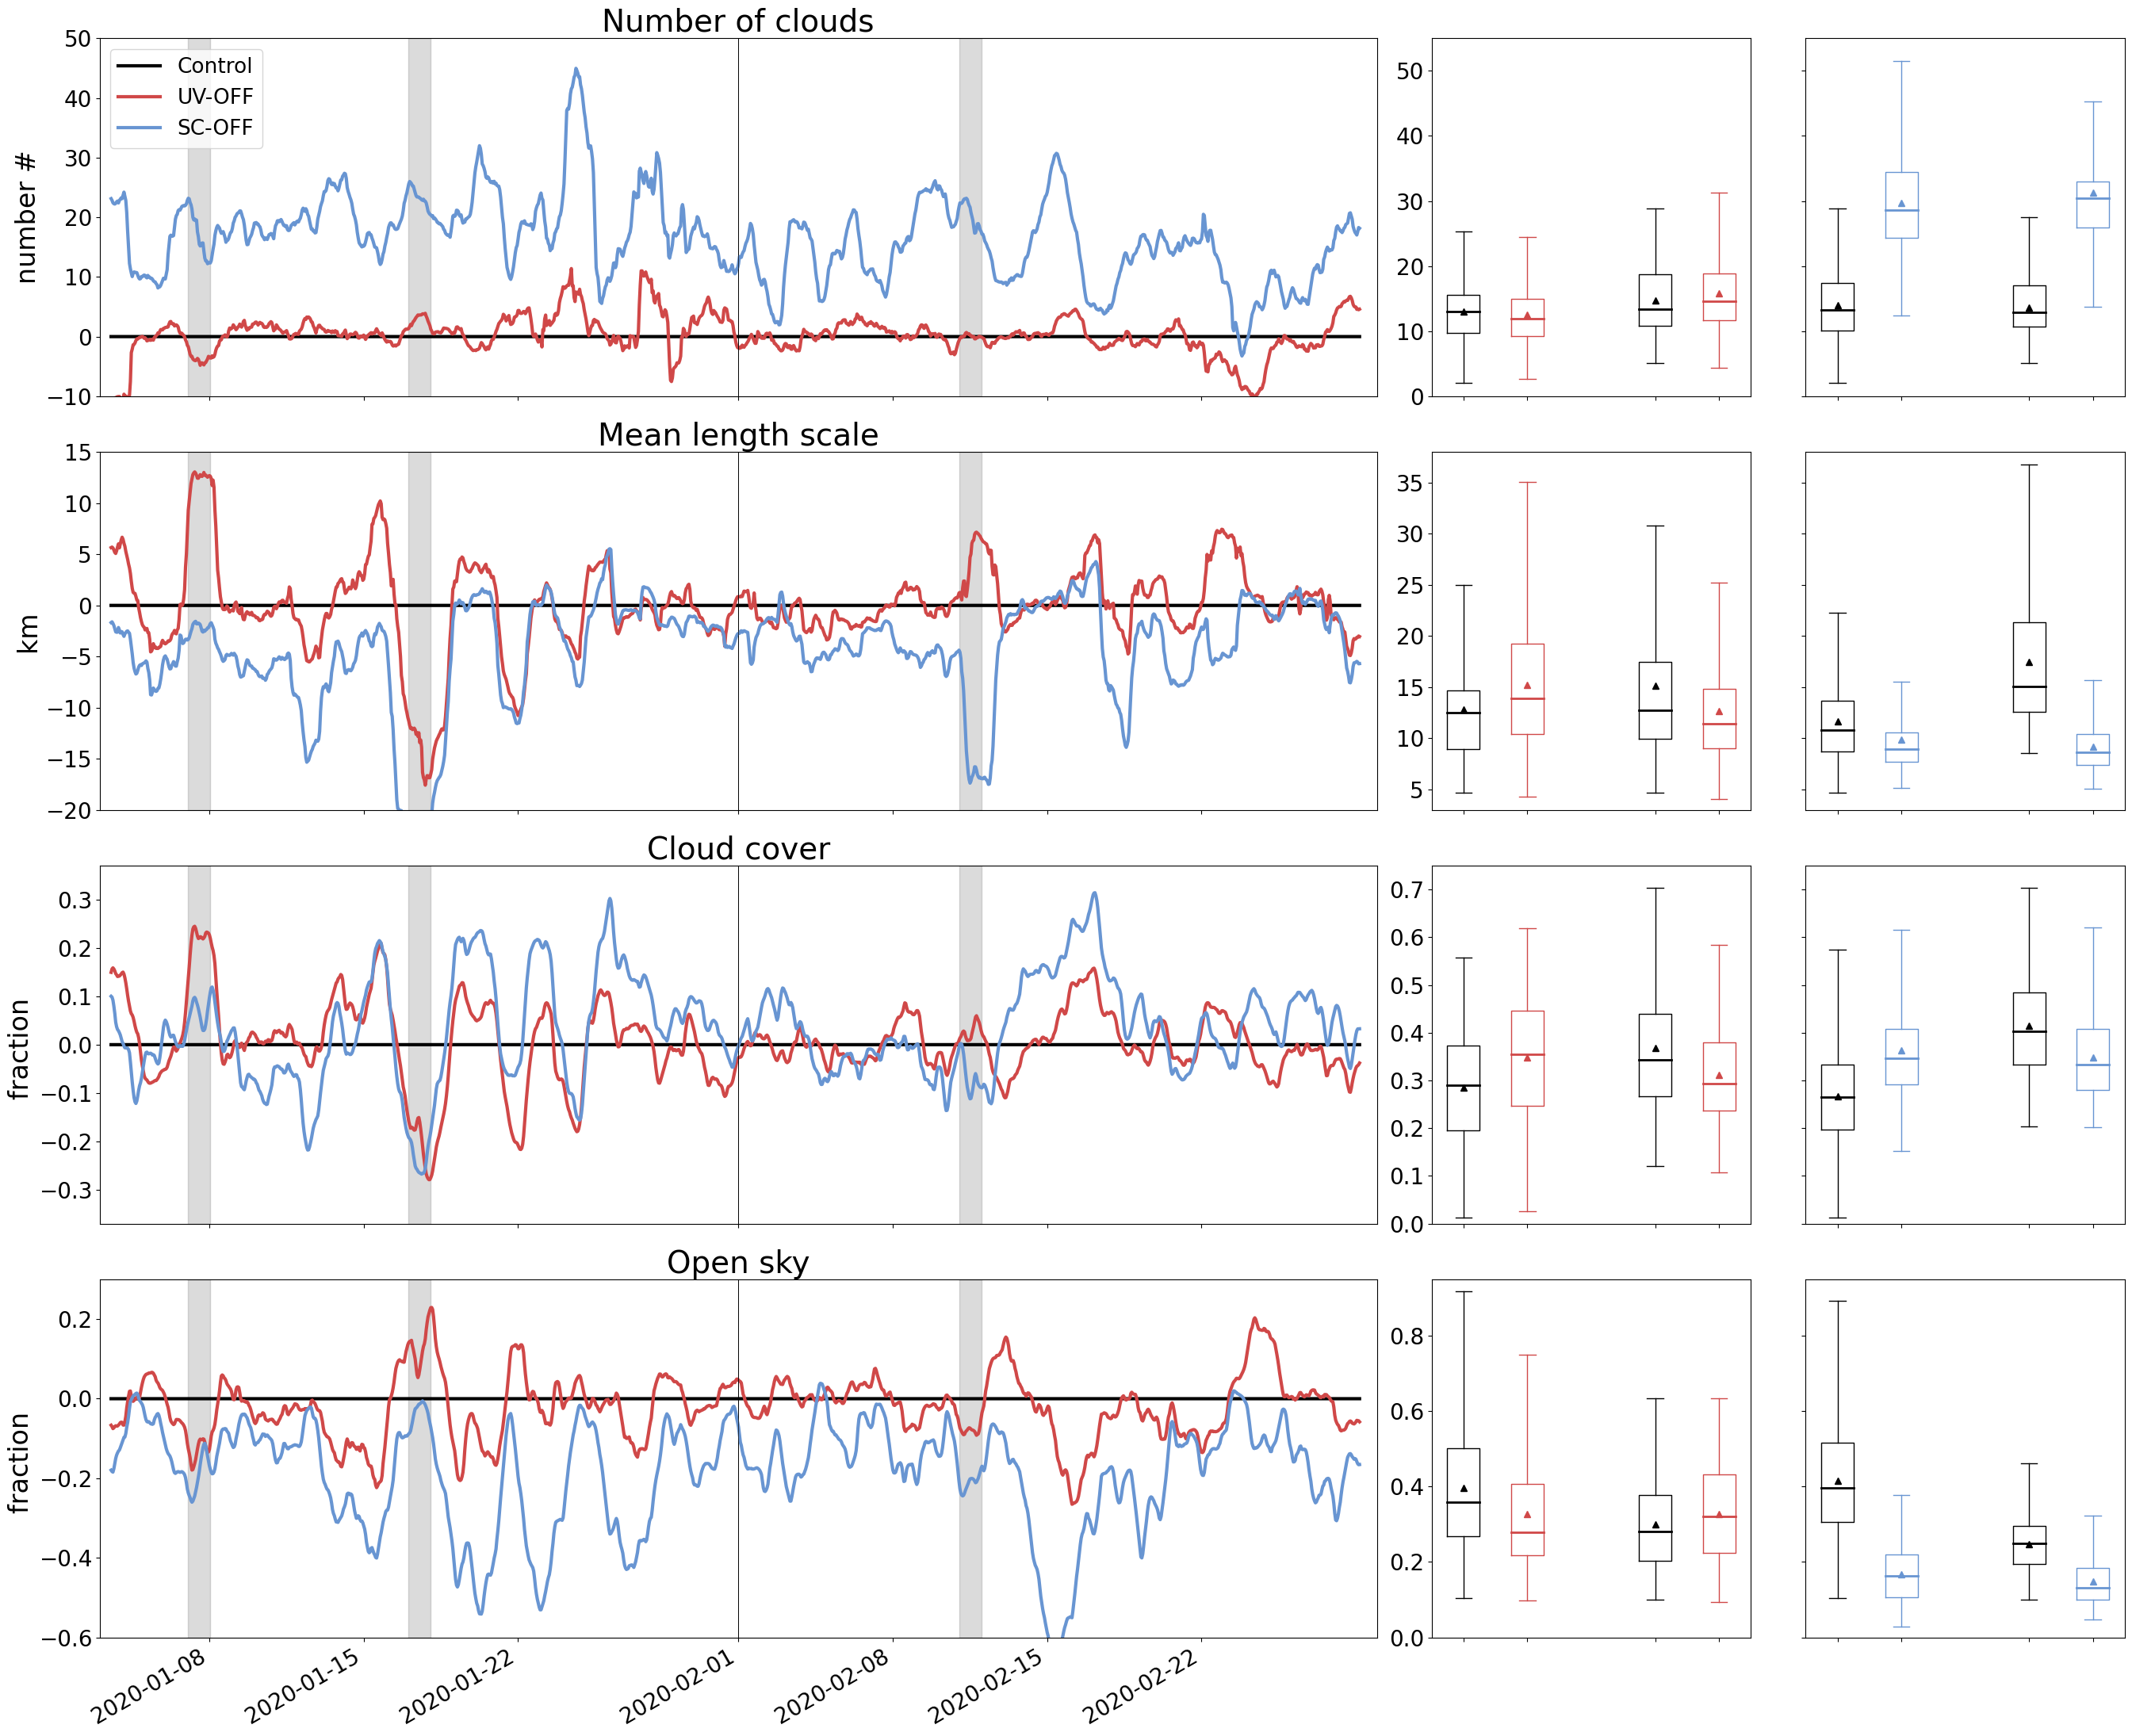

In [11]:
#%% Cloud statistics 2 boxplots
### ful time series 
for ds_org in [ds_org_4km_synopt,]:
    save_ext = '_4km_byCC'
    bottom, top = 0.1, 0.9
    left, right = 0.01, 0.9

    fig, axs = plt.subplots(4,3,figsize=(27,22), gridspec_kw={'width_ratios': [4,1,1]})
    fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, \
                        hspace=0.15, wspace=0.1)
    iteration = 0
    labels = []
    for ide, exp in enumerate(exps):
        iteration +=0.3
        label = lab[ide]  # Get the label from the 'lab' array
        labels.append(label)  # Append the label to the list
        for idx,var in enumerate(['num_objects','mean_length_scale','cloud_fraction','open_sky']):
#         for idx,var in enumerate(['num_objects','mean_length_scale']):
            if var =='cloud_fraction':
                factor = 1
                title  = 'Cloud cover'
                unit   = r'fraction '
                lim =   [-0.37,0.37]
                #lim =   [-0.08,0.2]
                # (harm2d_synopt[exp]['cc_1_5to4km']-harm2d_synopt['HA43h22tg3_clim_noHGTQS']['cc_1_5to4km'])\
                #     .plot(x='time',ax=axs[idx,0],ls=':',lw=3,c=col[ide])
            elif var =='num_objects':
                factor = 1
                title  = 'Number of clouds'
                unit   = r'number #'
                lim =   [-10,50]
                # (harm_obj_synopt[exp]['num_high_obj']-harm_obj_synopt['HA43h22tg3_clim_noHGTQS']['num_high_obj'])\
                #     .plot(x='time',c=col[ide],lw=3,ls=':',ax=axs[idx,0])
            elif var =='iorg':
                factor = 1
                title  = r'$I_{org}$'
                unit   = r'$I_{org}$'
            elif var == 'mean_length_scale':
                factor = 1
                title  ='Mean length scale'
                unit   = r'km'
                lim =   [-20,15]
                #lim =   [-3,10]
            elif var == 'open_sky':
                factor = 1
                title  ='Open sky'
                unit   = r'fraction '
                lim =   [-0.6,0.3]
            else:
                factor = 1
                title = var

            (ds_org[exp][var]-ds_org['HA43h22tg3_clim_noHGTQS'][var]).plot(\
                        x='time',ls='-',ax=axs[idx,0],lw=3,c=col[ide],label=lab[ide])        
            # vertical line between months  
            axs[idx,0].axvline(np.datetime64('2020-02-01T00'), color='k', linestyle='-', linewidth=0.5)
                
            # Fill the area between the vertical lines
            axs[idx,0].axvspan(np.datetime64('2020-01-07T00:30'),\
                             np.datetime64('2020-01-08T00:30'), alpha=0.1, color='grey')
            axs[idx,0].axvspan(np.datetime64('2020-01-17T00:30'),\
                             np.datetime64('2020-01-18T00:30'), alpha=0.1, color='grey')  
            axs[idx,0].axvspan(np.datetime64('2020-02-11T00:30'),\
                             np.datetime64('2020-02-12T00:30'), alpha=0.1, color='grey')  
            axs[idx,0].set_title(title,fontsize =28)
            axs[idx,0].set_ylabel(unit)
            axs[idx,0].set_ylim(lim)
            axs[idx,0].set_xlim((srt_time,end_time))

            ## boxplots
            if exp != exps[2]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    filtered_data = ds_org[exp].sel(time=group[exps[1]])[var].where(~ds_org[exp][var].isnull().compute(), drop=True).values
                    axs[idx,1].boxplot(filtered_data,\
                                positions=[round(ide+3*idy,1)],\
                            whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,\
                            medianprops=dict(color=col[ide], lw=2),boxprops=dict(color=col[ide]),\
                            whiskerprops=dict(color=col[ide]),capprops=dict(color=col[ide]),\
                            meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide]})  
                
                    axs[idx,1].tick_params(axis='x', which='major', labelsize=19)
            if exp != exps[1]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    filtered_data = ds_org[exp].sel(time=group[exps[2]])[var].where(~ds_org[exp][var].isnull().compute(), drop=True).values
                    axs[idx,2].boxplot(filtered_data,\
                                positions=[round(ide/2+3*idy,1)],\
                            whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,\
                            medianprops=dict(color=col[ide], lw=2),boxprops=dict(color=col[ide]),\
                            whiskerprops=dict(color=col[ide]),capprops=dict(color=col[ide]),\
                            meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide]})  
                    axs[idx,2].tick_params(axis='x', which='major', labelsize=19)

            axs[idx,1].set_ylabel('')
            axs[idx,2].set_xlabel('')
            axs[idx,1].tick_params(labelbottom=False) 
            axs[idx,2].tick_params(labelbottom=False) 
            axs[idx,2].tick_params(labelleft=False) 
            axs[idx,1].set_ylim([0,55])
    
    # plt.suptitle('Cloud mask for '+save_ext)
    axs[0,0].set_xlabel('')
    axs[0,0].tick_params(labelbottom=False) 
    axs[1,0].set_xlabel('')
    axs[1,0].tick_params(labelbottom=False) 
    axs[2,0].set_xlabel('')
    axs[2,0].tick_params(labelbottom=False) 
    axs[idx,0].set_xlabel('')
    axs[0,1].set_xlabel('')
    axs[1,1].set_xlabel('')
    axs[2,1].set_xlabel('')
    
    axs[0,1].set_ylim([0,55])
    axs[0,2].set_ylim([0,55])
    axs[1,1].set_ylim([3,38])
    axs[1,2].set_ylim([3,38])
    axs[2,1].set_ylim([0,0.75])
    axs[2,2].set_ylim([0,0.75])
    axs[3,1].set_ylim([0,0.95])
    axs[3,2].set_ylim([0,0.95])
    axs[0,0].legend(loc="upper left", fontsize=19)   
    plt.tight_layout()
    plt.savefig(figure_dir+'tmser_cl_metrics'+save_ext+'.pdf')

#### Figure 6

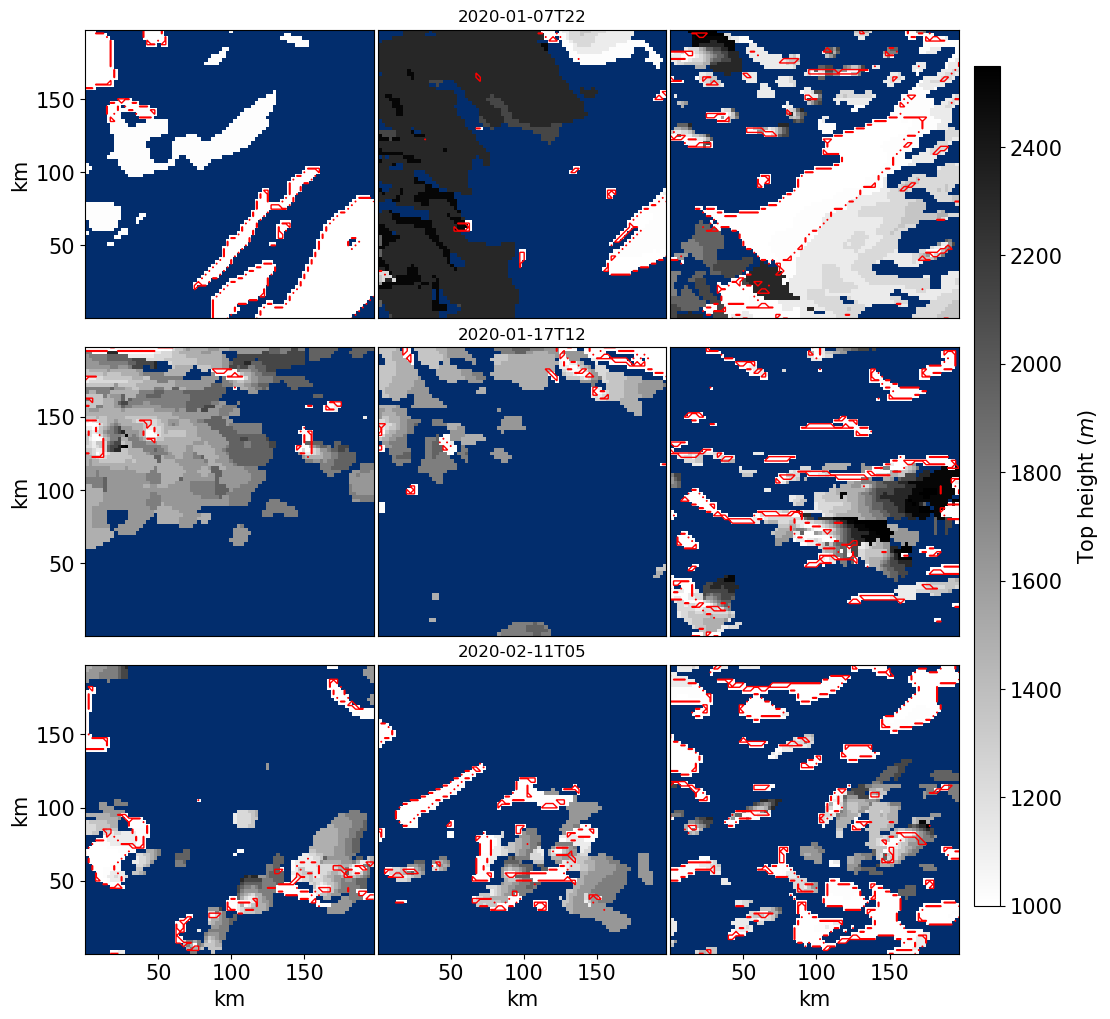

In [12]:
#%% aereal snapshot
klp=5
iz =200 # m
var_shade= 'cc_1km'
var ='cl_top'
vmin_ = 1000
vmax_ = 2550
cmap_ = 'binary'
    
ticklabels= np.array([50,100,150]) # in km 

dates = [np.datetime64('2020-01-07T22'),
         np.datetime64('2020-01-17T12'),
         np.datetime64('2020-02-11T05')]
name_ext = 'clouds'

fig, axs = plt.subplots(3,3,figsize=(13,12))
plt.subplots_adjust(right=0.8,wspace=0.001, hspace=0.1)
for idt, sel_time in enumerate(dates):
    for ide,exp in enumerate(exps):   
        # Extract the 'cloud_mask' variable as a numpy array
        if var_shade == 'cc_conv':
            cloud_mask = (harm3d_snap[exp]['cc_4km']-harm3d_snap[exp]['cc_1to4km']).sel(time=sel_time).values
        else: 
            cloud_mask = harm3d_snap[exp].sel(time=sel_time)[var_shade].values
        # Find connected components in the cloud_mask
        labels = measure.label(cloud_mask, connectivity=2)  # Assuming 8-connectivity
        # Create an empty array for the outline mask
        outline_mask = np.zeros_like(cloud_mask, dtype=bool)
        # Iterate through each connected component and find its boundary pixels
        for label in range(1, labels.max() + 1):
            component_mask = labels == label
            contour = measure.find_contours(component_mask, 0.8)
            # Add the boundary pixels to the outline mask
            for points in contour:
                outline_mask[np.round(points[:, 0]).astype(int), np.round(points[:, 1]).astype(int)] = True 
        
        axs[idt,ide].set_facecolor((2/255, 45/255, 109/255))
        if harm3d_snap[exp][var].ndim == 3:
            background = harm3d_snap[exp].sel(time=sel_time)[var].values
        else: 
            background = harm3d_snap[exp].sel(z=iz,method='nearest').sel(time=sel_time)[var].values            

        im = axs[idt,ide].imshow(background,cmap=cmap_,vmin=vmin_,vmax=vmax_, origin='lower',\
                extent=[harm3d_snap[exp].x.min(), harm3d_snap[exp].x.max(), harm3d_snap[exp].y.min(), harm3d_snap[exp].y.max()])
            
        # Set the alpha channel of outline_mask
        outline_mask_rgba = np.zeros((outline_mask.shape[0], outline_mask.shape[1], 4), dtype=np.uint8)
        if var == 'cl_top':
            outline_mask_rgba[..., :3] = [241, 90, 34]  # Set RGB to orange where True
        outline_mask_rgba[..., 3] = outline_mask * 255  # Set alpha to 255 (fully opaque) where True
        # Plot the outline with alpha blending
        # axs[idt,ide].imshow(outline_mask_rgba,
        #                     origin='lower',
        #                     extent=[harm3d_snap[exp].x.min(), harm3d_snap[exp].x.max(), harm3d_snap[exp].y.min(), harm3d_snap[exp].y.max()],
        #                     )
        contour = axs[idt, ide].contour(outline_mask, levels=[0.9], colors='r', linewidths=1,
                       extent=[harm3d_snap[exp].x.min(), harm3d_snap[exp].x.max(), harm3d_snap[exp].y.min(), harm3d_snap[exp].y.max()])

        axs[idt,ide].set_aspect('equal', adjustable='box')
        axs[idt,ide].set_title('')
        # if idt == 0:
        #     # axs[idt,ide].set_title(lab[ide],fontsize =22)
        ## x
        axs[idt,ide].set_xlabel('')
        axs[idt,ide].set_xticks([])
        if idt == 2:
            axs[idt,ide].set_xlabel('km',fontsize =15)
            axs[idt,ide].set_xticks(ticklabels*1000 +min(harm3d_snap[exp].x).values)
            axs[idt,ide].set_xticklabels(ticklabels,fontsize =15)
        ## y
        axs[idt,ide].set_ylabel('')
        axs[idt,ide].set_yticks([])
    axs[idt,0].set_yticks(ticklabels*1000 +min(harm3d_snap[exp].y).values)
    axs[idt,0].set_yticklabels(ticklabels,fontsize =15)
    axs[idt,0].set_ylabel('km',fontsize =15)
    axs[idt,1].set_title(str(sel_time))

cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar =fig.colorbar(im, cax=cbar_ax, orientation='vertical', shrink=0.8)
cbar.set_label(r'Top height ($m$)', labelpad=10,fontsize=15) 
cbar.ax.tick_params(labelsize=15) 
plt.savefig(figure_dir+'snapshots_'+var+name_ext+'.pdf')

#### Figure 7

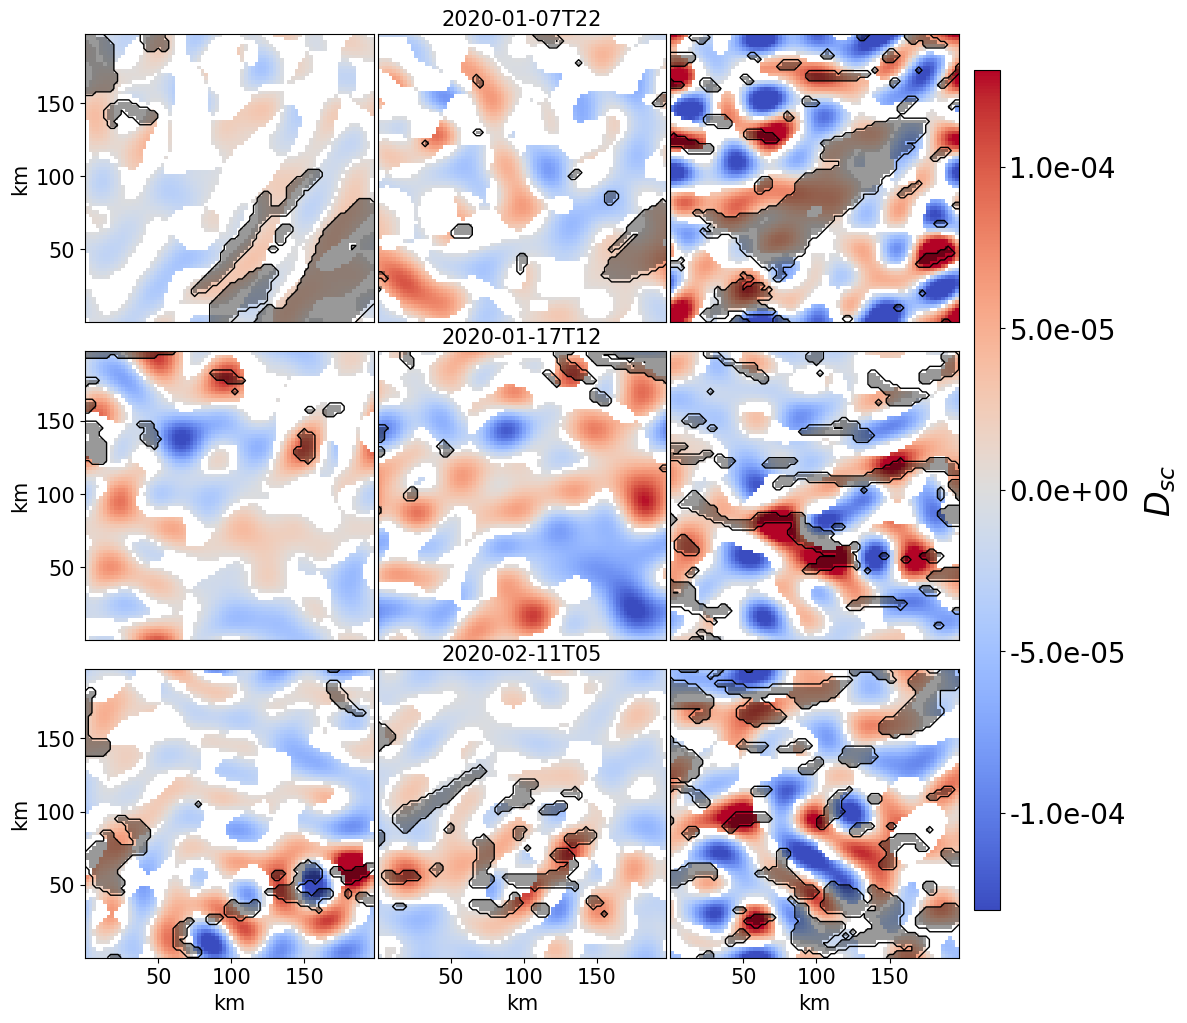

In [212]:
#%% aereal snapshot of smocs
# idtime= filtered[exp].time[15]
klp=5
iz =200 # m
var_shade= 'cc_1km'
var ='Dsc'
vmin_ = -0.00013
vmax_ = - vmin_
cmap_='coolwarm'
    
ticklabels= np.array([50,100,150]) # in km 

dates = [np.datetime64('2020-01-07T22'),
         np.datetime64('2020-01-17T12'),
         np.datetime64('2020-02-11T05')]
name_ext = 'div'

fig, axs = plt.subplots(3,3,figsize=(13,12))
plt.subplots_adjust(right=0.8,wspace=0.001, hspace=0.1)
for idt, sel_time in enumerate(dates):
    for ide,exp in enumerate(exps):   
        # Extract the 'cloud_mask' variable as a numpy array
        if var_shade == 'cc_conv':
            cloud_mask = (harm3d_snap[exp]['cc_4km']-harm3d_snap[exp]['cc_1to4km']).sel(time=sel_time).values
            cloud_mask = np.ma.masked_where(cloud_mask < 1, cloud_mask)
        else: 
            cloud_mask = harm3d_snap[exp].sel(time=sel_time)[var_shade].values
            cloud_mask = np.ma.masked_where(cloud_mask < 1, cloud_mask)
        cloud_mask_4km = harm3d_snap[exp].sel(time=sel_time)['cc_4km'].values
        cloud_mask_4km = np.ma.masked_where(cloud_mask_4km < 1, cloud_mask_4km)

        
        # Find connected components in the cloud_mask
        labels = measure.label(cloud_mask, connectivity=2)  # Assuming 8-connectivity
        # Create an empty array for the outline mask
        outline_mask = np.zeros_like(cloud_mask, dtype=bool)
        # Iterate through each connected component and find its boundary pixels
        for label in range(1, labels.max() + 1):
            component_mask = labels == label
            contour = measure.find_contours(component_mask, 0.3)
            # Add the boundary pixels to the outline mask
            for points in contour:
                outline_mask[np.round(points[:, 0]).astype(int), np.round(points[:, 1]).astype(int)] = True 
        
        if harm3d_snap[exp][var].ndim == 4:
            ### Convert from Divegence to Convergence adding a minus sign
            background = - harm3d_snap[exp].where(harm3d_snap[exp].smoc).sel(klp=klp,time=sel_time)[var].values 
        else:
            background = filterharm3d_snaped[exp].sel(z=iz,method='nearest').sel(klp=klp,time=sel_time)[var].values     

        im = axs[idt,ide].imshow(background,cmap=cmap_,vmin=vmin_,vmax=vmax_, origin='lower',\
                extent=[harm3d_snap[exp].x.min(), harm3d_snap[exp].x.max(), harm3d_snap[exp].y.min(), harm3d_snap[exp].y.max()])
            
        # Set the alpha channel of outline_mask
        outline_mask_rgba = np.zeros((outline_mask.shape[0], outline_mask.shape[1], 4), dtype=np.uint8)
        outline_mask_rgba[..., 3] = outline_mask * 255  # Set alpha to 255 (fully opaque) where True
        contour = axs[idt, ide].contour(outline_mask, levels=[0.9], colors='k', linewidths=1,
                       extent=[harm3d_snap[exp].x.min(), harm3d_snap[exp].x.max(), harm3d_snap[exp].y.min(), harm3d_snap[exp].y.max()])
        #cloud shading
        axs[idt,ide].imshow(cloud_mask,cmap='binary_r', origin='lower',alpha=0.4,\
                extent=[harm3d_snap[exp].x.min(), harm3d_snap[exp].x.max(), harm3d_snap[exp].y.min(), harm3d_snap[exp].y.max()])

        # second cloud shading including anvils
        # axs[idt,ide].imshow(cloud_mask_4km,cmap='binary_r', origin='lower',alpha=0.5,\
        #         extent=[harm3d_snap[exp].x.min(), harm3d_snap[exp].x.max(), harm3d_snap[exp].y.min(), harm3d_snap[exp].y.max()])

        axs[idt,ide].set_aspect('equal', adjustable='box')
        axs[idt,ide].set_title('')
        # if idt == 0:
        #     # axs[idt,ide].set_title(lab[ide],fontsize =22)
        ## x
        axs[idt,ide].set_xlabel('')
        axs[idt,ide].set_xticks([])
        if idt == 2:
            axs[idt,ide].set_xlabel('km',fontsize =15)
            axs[idt,ide].set_xticks(ticklabels*1000 +min(harm3d_snap[exp].x).values)
            axs[idt,ide].set_xticklabels(ticklabels,fontsize =15)
        ## y
        axs[idt,ide].set_ylabel('')
        axs[idt,ide].set_yticks([])
    axs[idt,0].set_yticks(ticklabels*1000 +min(harm3d_snap[exp].y).values)
    axs[idt,0].set_yticklabels(ticklabels,fontsize =15)
    axs[idt,0].set_ylabel('km',fontsize =15)
    axs[idt,1].set_title(str(sel_time),fontsize=15)

cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar =fig.colorbar(im, cax=cbar_ax, orientation='vertical',format='%.1e')
cbar.set_label(r'$D_{sc}$', labelpad=10) 
plt.savefig(figure_dir+'snapshots_'+var+name_ext+'.pdf')

#### Figure 8

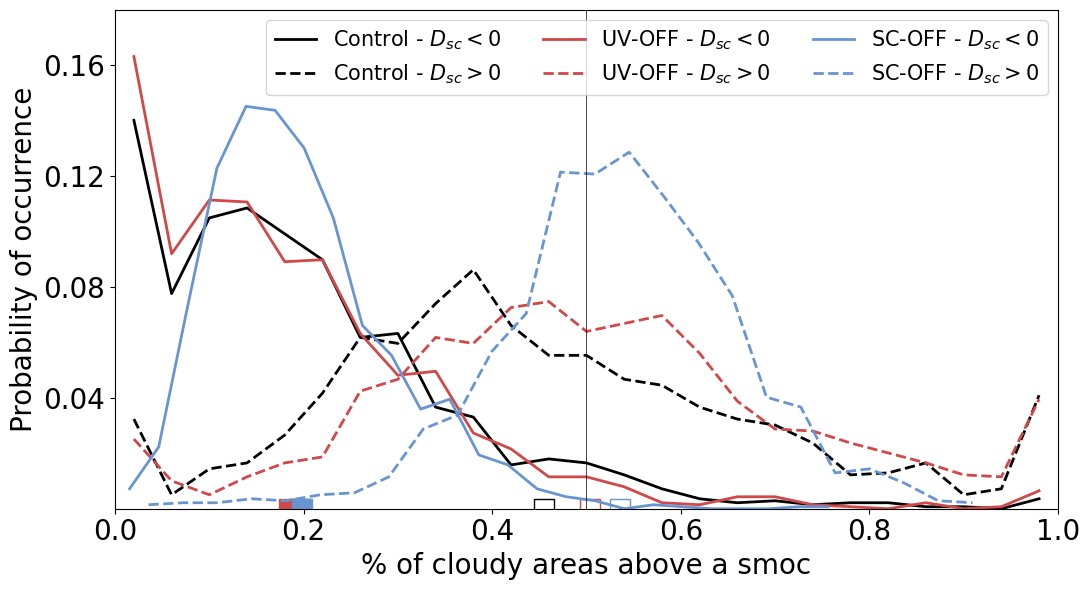

In [14]:
#%% Histogram of conv/dive smocs below a cloud
# what is the percentage of cloudy pixel that are above a converging / diverging smoc? 
# Plot the histogram
var_cloud ='1'
fig, ax = plt.subplots(figsize=(11,6))
for ide,exp in enumerate(exps): 
    ## diverging
    counts, edges, patches = ax.hist(harm2d[exp][var_cloud+'cl_frac_on_dive'], bins=25,facecolor='none')
    # Plot a line connecting the tops of the bars
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    scaled_counts = counts / len(harm2d[exp].time)  # Scale y-axis values by total number of occurences
    ax.plot(bin_centers, scaled_counts,lw=2, linestyle='-', color=col[ide],label=lab[ide]+r' - $D_{sc}<0$')
    # Add a squared mark at the bottom indicating the mean for diverging
    mean_diverging = np.mean(harm2d[exp][var_cloud+'cl_frac_on_dive'])
    ax.plot(mean_diverging, 0, marker='s',  markersize=15,linestyle='None', color=col[ide])
    
    ## converging 
    counts, edges, patches = ax.hist(harm2d[exp][var_cloud+'cl_frac_on_conv'], bins=25,facecolor='none')
    # Plot a line connecting the tops of the bars
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    scaled_counts = counts / len(harm2d[exp].time)  # Scale y-axis values by total number of occurences
    ax.plot(bin_centers, scaled_counts,lw=2, linestyle='--', color=col[ide],label=lab[ide]+r' - $D_{sc}>0$')
    # Add a squared mark at the bottom indicating the mean for converging
    mean_converging = np.mean(harm2d[exp][var_cloud+'cl_frac_on_conv'])
    ax.plot(mean_converging, 0, marker='s', markersize=15,linestyle='None',mfc='none', color=col[ide])
    
# Add a vertical black line at x=0.5
ax.axvline(x=0.5, color='black', linestyle='-', linewidth=0.5)
ax.set_xlim(0, 1)
# Set the y-axis ticks and format tick labels to display 2 decimals
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
#
ax.set_ylim(0, 0.18)
# ax.set_title('% of cloudy areas above a smoc',fontsize = 20)
ax.set_xlabel('% of cloudy areas above a smoc',fontsize=20)
ax.set_ylabel('Probability of occurrence',fontsize=20)
ax.legend(ncol=3,fontsize=15)
plt.tight_layout()
plt.savefig(figure_dir+'probab_cl_on_smoc.pdf')


#### Figure 9

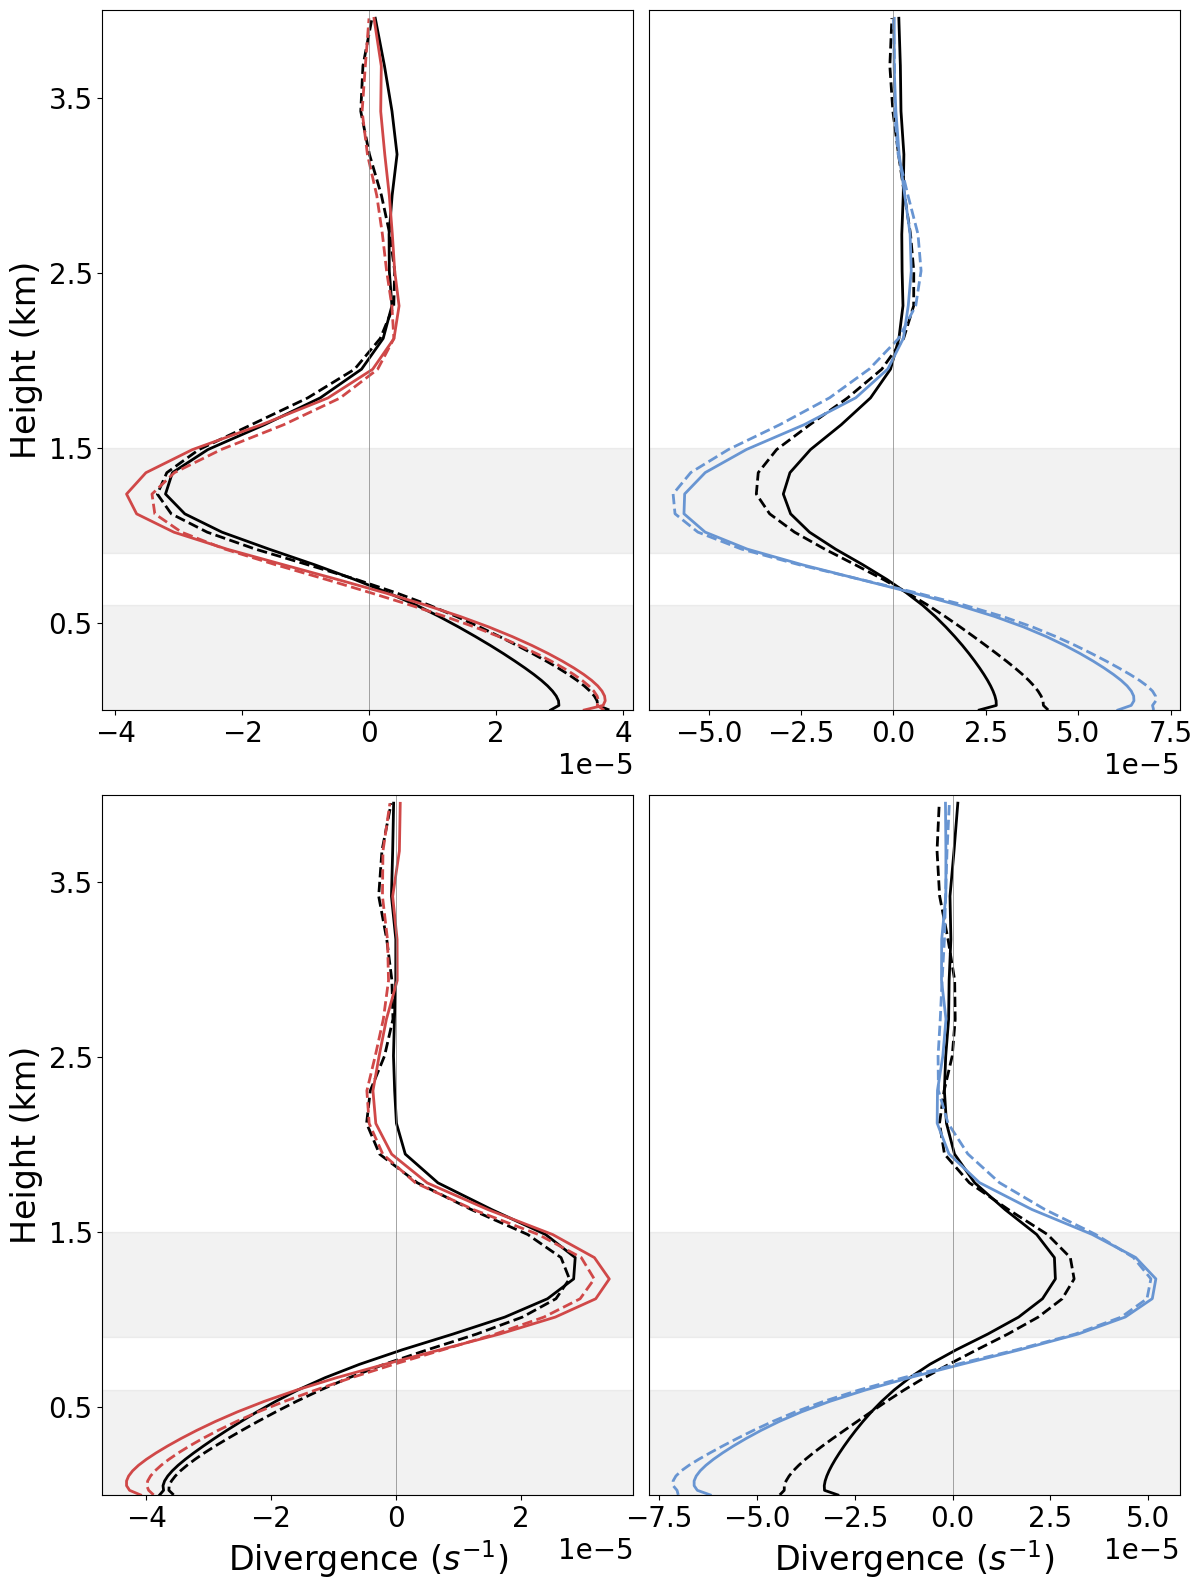

In [15]:
#%% Divergence profiles
fig, axs = plt.subplots(2,2,figsize=(12,16))
for idx, var in enumerate(['_on_conv','_on_dive']):
    for ide, exp in enumerate(exps[1:]):
        ## first plot the control 
        # sleect all SMOCs       
        p1,= (-harm_subsamp[exps[0]]['div_f'+var]).sel(time = time_CC_exp_is_larger[exp])\
            .sel(klp=5,z=slice(0,4)).mean('time')\
            .plot(y='z',lw=2,ls='-',c=col[0],ax=axs[idx,ide],label=lab[0])
        p1,= (-harm_subsamp[exps[0]]['div_f'+var]).sel(time = time_CC_exp_is_smaller[exp])\
            .sel(klp=5,z=slice(0,4)).mean('time')\
            .plot(y='z',lw=2,ls='--',c=col[0],ax=axs[idx,ide],label=lab[0])
        ## then the experiments
        p2,=(-harm_subsamp[exp]['div_f'+var]).sel(time = time_CC_exp_is_larger[exp])\
            .sel(klp=5,z=slice(0,4)).mean('time')\
            .plot(y='z',lw=2,ls='-',c=col[ide+1],label=lab[ide+1]+r'$_{CC_{'+lab[ide+1]+'> ctrl}}$',ax=axs[idx,ide])
        p2,=(-harm_subsamp[exp]['div_f'+var]).sel(time = time_CC_exp_is_smaller[exp])\
            .sel(klp=5,z=slice(0,4)).mean('time')\
            .plot(y='z',lw=2,ls='--',c=col[ide+1],label=lab[ide+1]+r'$_{CC_{'+lab[ide+1]+'< ctrl}}$',ax=axs[idx,ide])
        ##
        axs[idx,ide].set_ylim([0,4])
        axs[idx,ide].set_yticks([]) 
        axs[idx,ide].set_ylabel('')
        axs[idx,ide].set_xlabel('')
        axs[idx,ide].axvline(0, color='grey', linestyle='-', linewidth=0.5)
        axs[idx,ide].axhspan(sc_layer_base, sc_layer_top, alpha=0.1, color='grey')
        axs[idx,ide].axhspan(c_layer_base, c_layer_top, alpha=0.1, color='grey')
        axs[idx,ide].set_title('')
        # axs[idx,ide].spines['top'].set_visible(False)
        # axs[idx,ide].spines['right'].set_visible(False)
    axs[idx,0].set_ylabel('Height (km)')
    axs[idx,0].set_yticks([0.5,1.5,2.5,3.5]) 
axs[1,0].set_xlabel(r'Divergence ($s^{-1}$)')
axs[1,1].set_xlabel(r'Divergence ($s^{-1}$)')
# axs[0,0].legend(fontsize=16,ncol=2)
# axs[0,1].legend(fontsize=16,ncol=2)
# plt.suptitle('Divergence profiles')
plt.tight_layout()
plt.savefig(figure_dir+'divergence_profiles_nolegend.pdf')

#### Figure 10

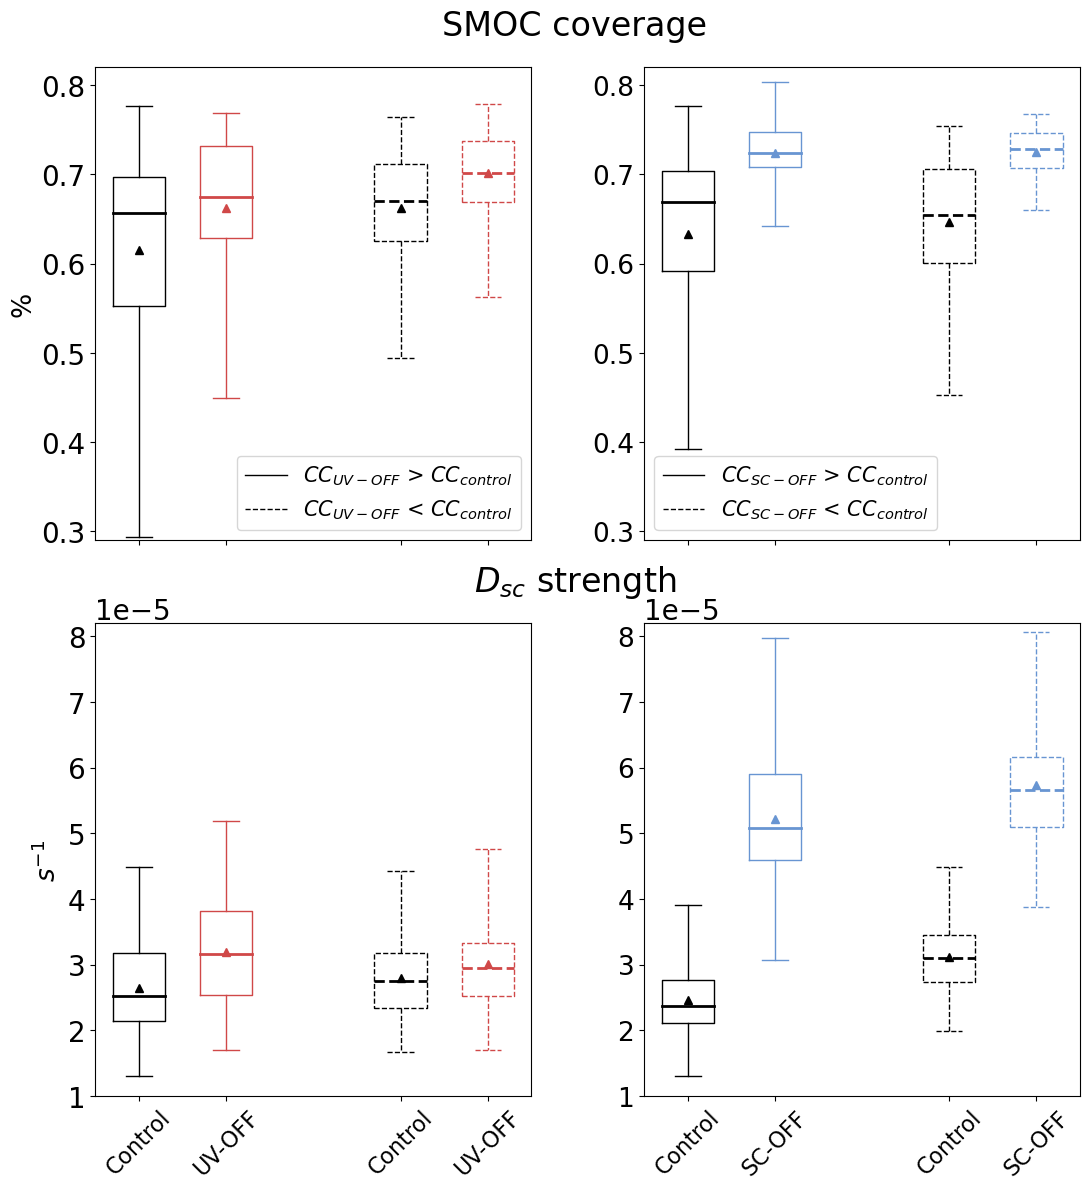

In [169]:
#%% Cloud statistics for SMOCS coverage and strength only boxplots
### full time series 
klp = 5 
vars_to_plot = ['cloud_fraction','sc_strength']
for id_sm, ds_org in enumerate([ds_org_smoc_mean_synopt,]):
    save_ext = '_smocs_byCC'
    bottom, top = 0.1, 0.9
    left, right = 0.01, 0.9
    fig, axs = plt.subplots(len(vars_to_plot),2,figsize=(11,12), gridspec_kw={'width_ratios': [1,1]})
    fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, \
                        hspace=0.1, wspace=0.15)
    iteration = 0
    labels = []
    legend_handles1 = []
    legend_handles2 = []
    for ide, exp in enumerate(exps):
        iteration +=1
        label = lab[ide]  # Get the label from the 'lab' array
        labels.append(label)  # Append the label to the list
        for idx,var in enumerate(vars_to_plot):
            if var =='cloud_fraction':
                factor = 1
                title  = 'SMOC coverage'
                unit   = r'%'
                lim =   [None,None]
            elif var =='sc_strength':
                factor = 1
                title  = r'$D_{sc}$ strength'
                unit   = r'$s^{-1}$'
                lim =   [None,None]
            else:
                factor = 1
                title = var
                unit   = r''
                lim =   [None,None]

            # axs[idx].set_xlim(0,23)
            axs[idx,0].set_title(title,fontsize =28)
            axs[idx,0].set_ylabel(unit)
            ## boxplots
            if exp != exps[2]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    filtered_data = ds_org[exp].sel(time=group[exps[1]]).sel(klp=klp)[var].where(~ds_org[exp].sel(klp=klp)[var].isnull().compute(), drop=True).values
                    plot1 = axs[idx,0].boxplot(filtered_data,positions=[round(ide+3*idy,1)],
                            whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.6,
                            medianprops=dict(color=col[ide], lw=2,linestyle=sty[idy]),
                            boxprops=dict(color=col[ide],linestyle=sty[idy]),
                            whiskerprops=dict(color=col[ide],linestyle=sty[idy]),
                            capprops=dict(color=col[ide],linestyle=sty[idy]),\
                            meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide],'linestyle':sty[idy]})  
                    legend_handles1.append(plot1["boxes"][0])
                    axs[idx,0].tick_params(axis='x', which='major', labelsize=19)
            if exp != exps[1]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    filtered_data = ds_org[exp].sel(time=group[exps[2]]).sel(klp=klp)[var].where(~ds_org[exp].sel(klp=klp)[var].isnull().compute(), drop=True).values
                    plot2 = axs[idx,1].boxplot(filtered_data,positions=[round(ide/2+3*idy,1)],
                            whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.6,
                            medianprops=dict(color=col[ide], lw=2,linestyle=sty[idy]),
                            boxprops=dict(color=col[ide],linestyle=sty[idy]),
                            whiskerprops=dict(color=col[ide],linestyle=sty[idy]),
                            capprops=dict(color=col[ide],linestyle=sty[idy]),\
                            meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide],'linestyle':sty[idy]})  
                    legend_handles2.append(plot2["boxes"][0])
                    axs[idx,1].tick_params(axis='both', which='major',labelsize=19)

            axs[idx,0].set_title(title,fontsize =24,x=1.1,y=1.05)
            axs[idx,0].set_ylabel(unit,fontsize=19)
            
    axs[0,0].set_xlabel('')
    axs[0,1].set_xlabel('')
    axs[0,0].tick_params(labelbottom=False) 
    axs[0,1].tick_params(labelbottom=False) 

    axs[1,0].set_xticklabels([labels[0],labels[0],labels[1],labels[1]], rotation=45 )
    axs[1,0].tick_params(axis='x', which='major', labelsize=16)
    axs[1,1].set_xticklabels([labels[0],labels[0],labels[2],labels[2]], rotation=45 )
    axs[1,1].tick_params(axis='x', which='major', labelsize=16)

    for idy in [0,1]:
        axs[0,idy].set_ylim([0.29,0.82])
        axs[1,idy].set_ylim([1e-5,8.2e-5])

    axs[0, 0].legend(handles=[legend_handles1[0],legend_handles1[3]],
                     labels=[r'$CC_{'+lab[1]+'}$ > $CC_{control}}$','$CC_{'+lab[1]+'}$ < $CC_{control}}$'],
                fontsize=15)
    axs[0, 1].legend(handles=[legend_handles2[0],legend_handles2[3]],
                     labels=[r'$CC_{'+lab[2]+'}$ > $CC_{control}}$','$CC_{'+lab[2]+'}$ < $CC_{control}}$'],
                fontsize=15)
 
    plt.tight_layout()
    plt.savefig(figure_dir+'bxplt_smoc_metric'+save_ext+'.pdf')

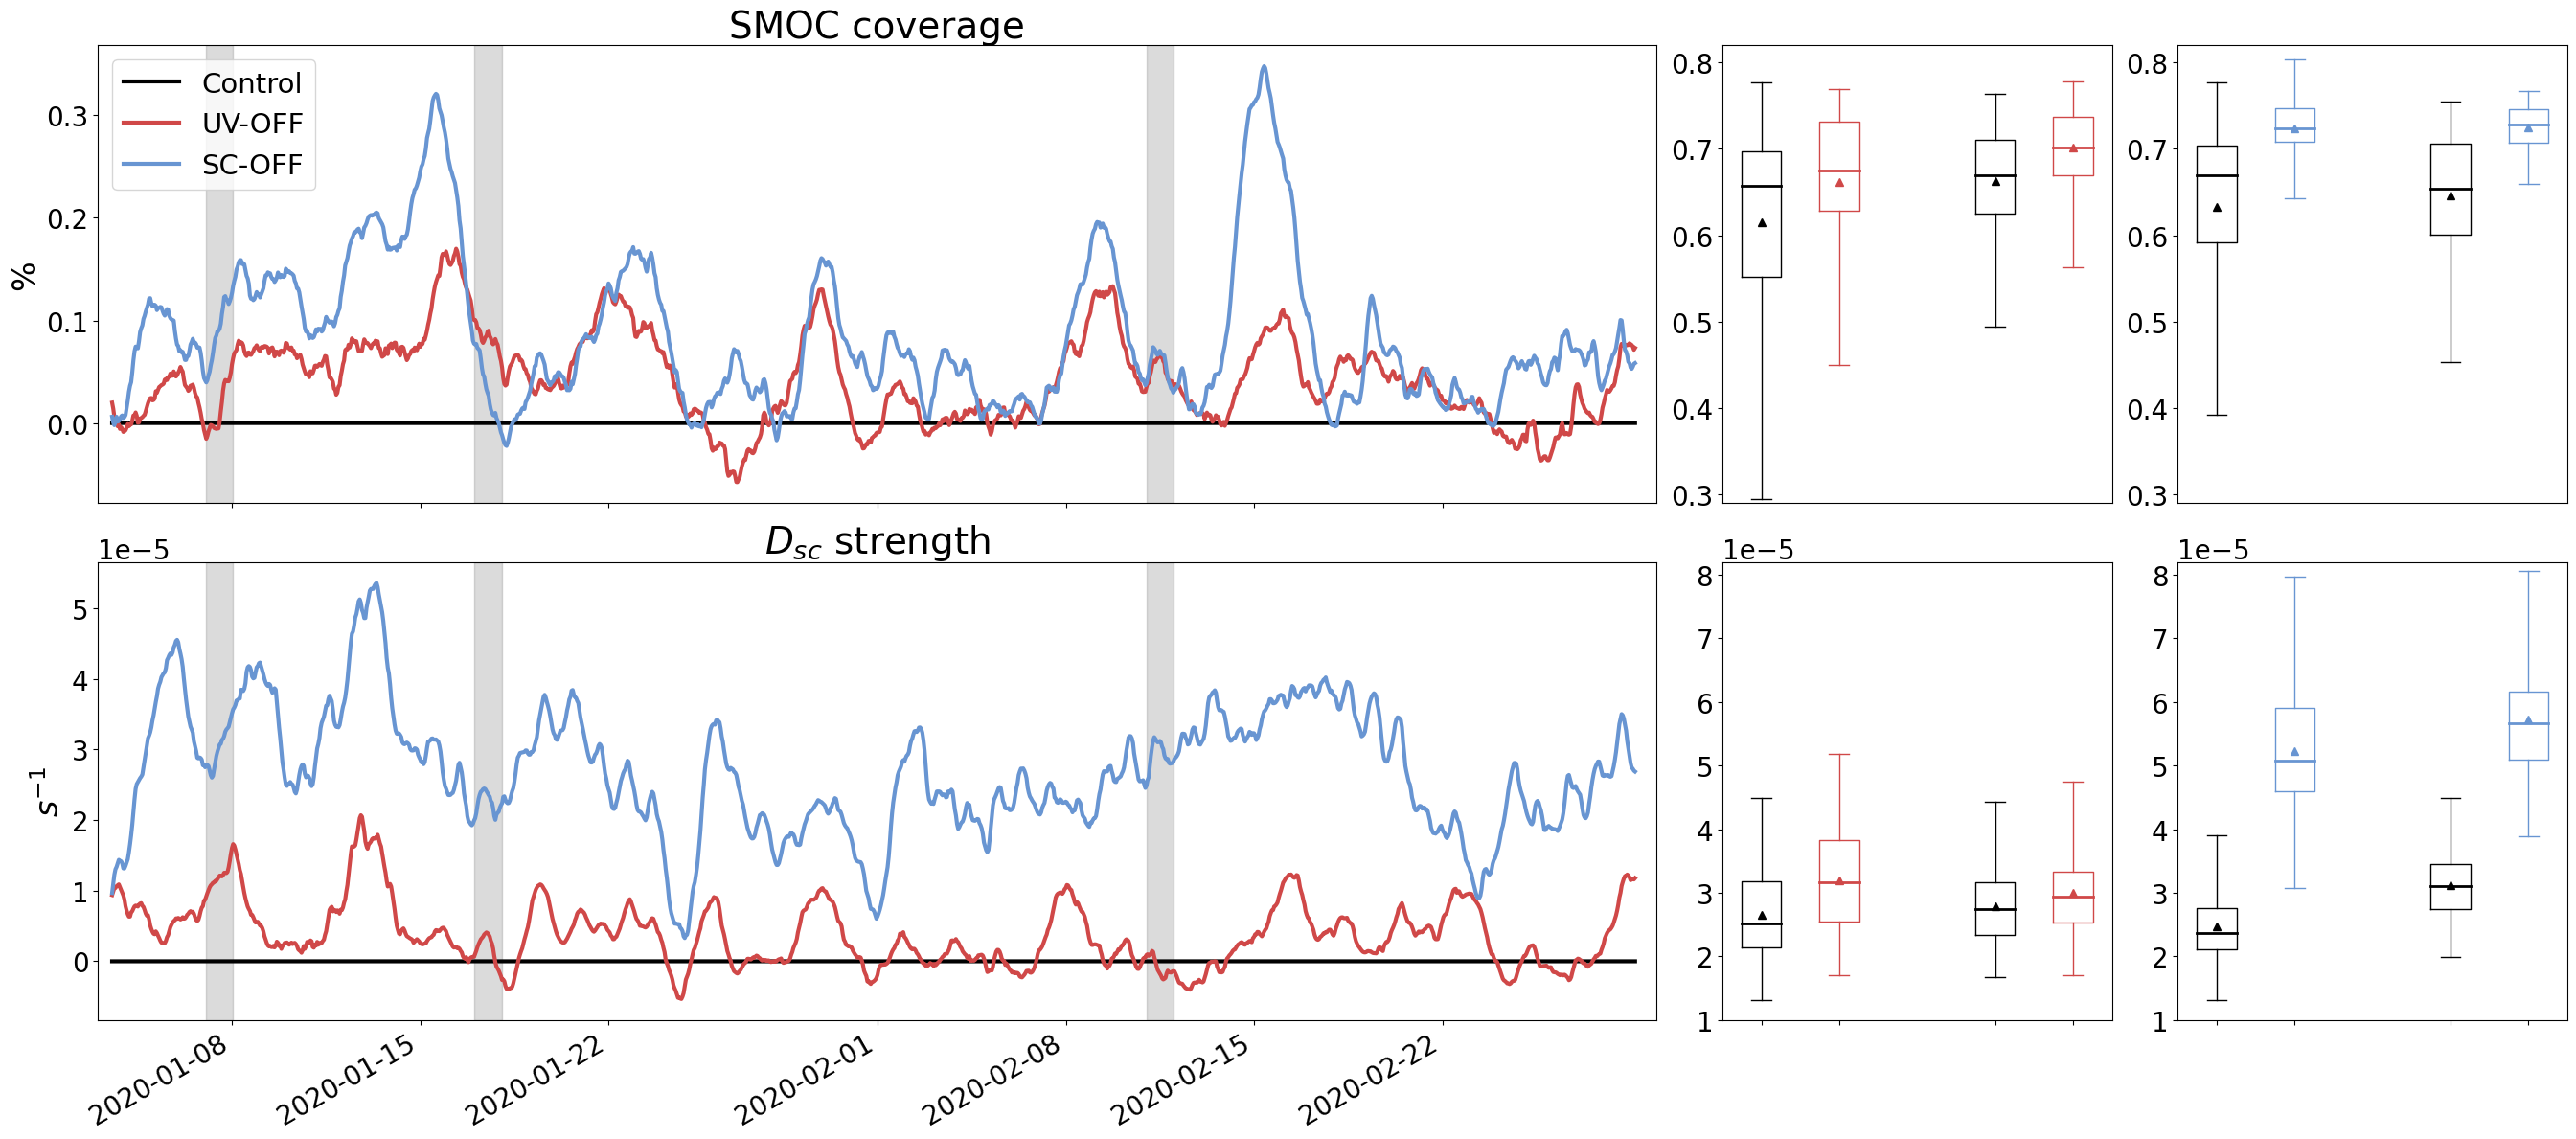

In [162]:
#%% Cloud statistics for SMOCS coverage and strength 2 boxplots
### full time series 
klp = 5 
vars_to_plot = ['cloud_fraction','sc_strength']
for id_sm, ds_org in enumerate([ds_org_smoc_mean_synopt,]):
    save_ext = '_smocs_byCC'
    bottom, top = 0.1, 0.9
    left, right = 0.01, 0.9
    fig, axs = plt.subplots(len(vars_to_plot),3,figsize=(27,12), gridspec_kw={'width_ratios': [4,1,1]})
    fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, \
                        hspace=0.15, wspace=0.1)
    iteration = 0
    labels = []
    for ide, exp in enumerate(exps):
        iteration +=1
        label = lab[ide]  # Get the label from the 'lab' array
        labels.append(label)  # Append the label to the list
        for idx,var in enumerate(vars_to_plot):
            if var =='cloud_fraction':
                factor = 1
                title  = 'SMOC coverage'
                unit   = r'%'
                lim =   [None,None]
            elif var =='sc_strength':
                factor = 1
                title  = r'$D_{sc}$ strength'
                unit   = r'$s^{-1}$'
                lim =   [None,None]
            else:
                factor = 1
                title = var
                unit   = r''
                lim =   [None,None]
            (ds_org[exp].sel(klp=klp)[var]-ds_org['HA43h22tg3_clim_noHGTQS'].sel(klp=klp)[var]).plot(\
                        x='time',ls=['-','--'][id_sm],ax=axs[idx,0],lw=3,c=col[ide],label=lab[ide])        
            # vertical line between months  
            axs[idx,0].axvline(np.datetime64('2020-02-01T00'), color='k', linestyle='-', linewidth=0.5)
            # Fill the area between the vertical lines
            axs[idx,0].axvspan(np.datetime64('2020-01-07T00:30'),\
                             np.datetime64('2020-01-08T00:30'), alpha=0.1, color='grey')
            axs[idx,0].axvspan(np.datetime64('2020-01-17T00:30'),\
                             np.datetime64('2020-01-18T00:30'), alpha=0.1, color='grey')  
            axs[idx,0].axvspan(np.datetime64('2020-02-11T00:30'),\
                             np.datetime64('2020-02-12T00:30'), alpha=0.1, color='grey')

            # axs[idx].set_xlim(0,23)
            axs[idx,0].set_title(title,fontsize =28)
            axs[idx,0].set_ylabel(unit)
#             axs[idx,0].set_ylim(lim)
            axs[idx,0].set_xlim((srt_time,end_time))
            ## boxplots
            if exp != exps[2]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    filtered_data = ds_org[exp].sel(time=group[exps[1]]).sel(klp=klp)[var].where(~ds_org[exp].sel(klp=klp)[var].isnull().compute(), drop=True).values
                    axs[idx,1].boxplot(filtered_data,\
                                positions=[round(ide+3*idy,1)],\
                            whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,\
                            medianprops=dict(color=col[ide], lw=2),boxprops=dict(color=col[ide]),\
                            whiskerprops=dict(color=col[ide]),capprops=dict(color=col[ide]),\
                            meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide]})  
                
                    axs[idx,1].tick_params(axis='x', which='major', labelsize=19)
            if exp != exps[1]:
                for idy,group in enumerate([time_CC_exp_is_larger,time_CC_exp_is_smaller]):
                    filtered_data = ds_org[exp].sel(time=group[exps[2]]).sel(klp=klp)[var].where(~ds_org[exp].sel(klp=klp)[var].isnull().compute(), drop=True).values
                    axs[idx,2].boxplot(filtered_data,\
                                positions=[round(ide/2+3*idy,1)],\
                            whis=1.8,showfliers=False,showmeans=True,meanline=False,widths=0.51,\
                            medianprops=dict(color=col[ide], lw=2),boxprops=dict(color=col[ide]),\
                            whiskerprops=dict(color=col[ide]),capprops=dict(color=col[ide]),\
                            meanprops={"markerfacecolor":col[ide],'markeredgecolor':col[ide]})  
                    axs[idx,2].tick_params(axis='x', which='major', labelsize=19)


            if idx < len(vars_to_plot)-1:
                axs[idx,2].set_ylabel('')
                axs[idx,1].set_ylabel('')
                axs[idx,1].set_xlabel('')
                axs[idx,2].set_xlabel('')
                axs[idx,1].set_xticks([])
                axs[idx,2].set_xticks([])
                axs[idx,0].tick_params(labelbottom=False) 
                axs[idx,1].tick_params(labelbottom=False) 

            axs[idx,0].set_xlabel('')
            axs[idx,1].set_ylabel('')
            axs[idx,2].set_xlabel('')
            axs[idx,1].tick_params(labelbottom=False) 
            axs[idx,2].tick_params(labelbottom=False) 
    # plt.suptitle('Cloud mask for '+save_ext)
    axs[0,1].set_ylim([0.29,0.82])
    axs[0,2].set_ylim([0.29,0.82])
    axs[1,1].set_ylim([1e-5,8.2e-5])
    axs[1,2].set_ylim([1e-5,8.2e-5])
    axs[0,0].legend(loc="upper left", fontsize=21)   
    plt.tight_layout()
    plt.savefig(figure_dir+'tmser_cl_metrics'+save_ext+'.pdf')

#### Figure 11

#### Figure 12

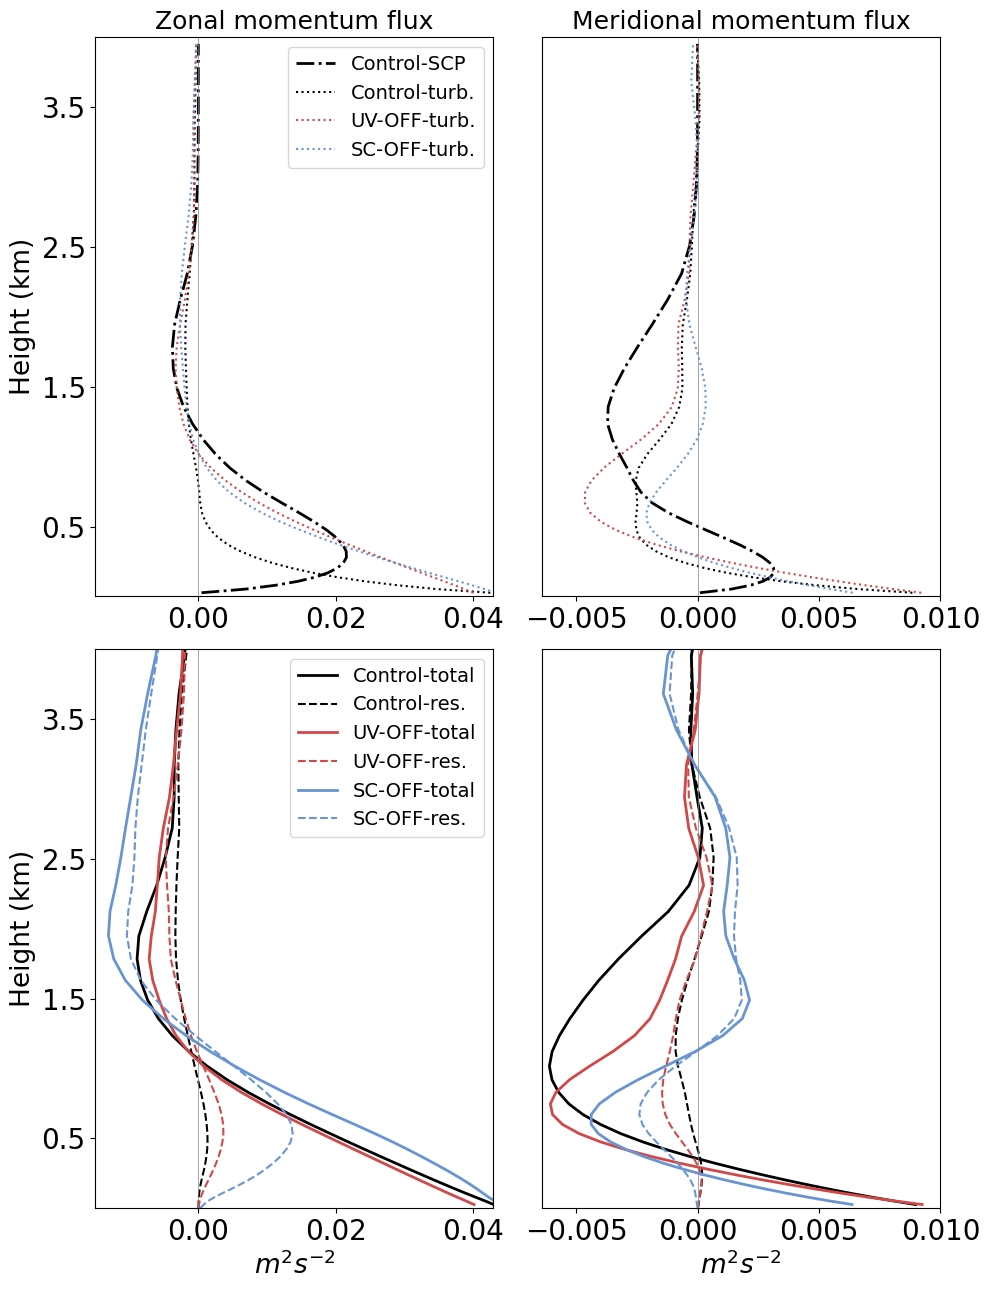

In [218]:
#%% Momentum fluxes
n_xplots = 2
n_yplots = 2
cmap_ = cm.coolwarm

para_res = 'conv'
sel_time=harm2d[exp].time

fig, axs = plt.subplots(n_yplots,n_xplots,figsize=(10,13))
for idx, var in enumerate(['u','v']):
    for ide,exp in enumerate(exps):
    
        ## fluxes ##
        ## parameterised by SC
        if exp ==exps[0]:
            (harm2d[exp][var+'flx_conv_dry']+harm2d[exp][var+'flx_conv_moist']).sel(z=slice(0.01,4)).mean('time')\
                    .plot(y='z',lw=2,ls='-.',ax=axs[0,idx],c=col[ide],label=lab[ide]+'-SCP')
        ## parameterised by SC + turb.
        # harm2d[exp][var+'_flx_param_tot'].sel(z=slice(0.01,4)).mean('time')\
        #         .plot(y='z',lw=1.5,ax=axs[idx,0],c=col[ide],label=lab[ide])
        ## parameterised by turb.
        harm2d[exp][var+'flx_turb'].sel(z=slice(0.01,4)).mean('time')\
                .plot(y='z',lw=1.5,ls=':',ax=axs[0,idx],c=col[ide],label=lab[ide]+'-turb.')
        ## total
        (harm_subsamp[exp][var+'flx_resolved']+harm2d[exp][var+'_flx_param_tot']).mean('time')\
            .plot(y='z',lw=2,ls='-',ax=axs[1,idx],c=col[ide],label=lab[ide]+'-total')
        ## resolved
        harm_subsamp[exp][var+'flx_resolved'].mean('time')\
            .plot(y='z',lw=1.5,ls='--',ax=axs[1,idx],c=col[ide],label=lab[ide]+'-res.')

    axs[0,idx].axvline(0,c='grey',lw=0.5)
    axs[1,idx].axvline(0,c='grey',lw=0.5)
    
    axs[0,idx].set_ylim((0,4)) 
    axs[1,idx].set_ylim((0,4)) 
    axs[idx,0].set_ylabel('Height (km)',fontsize=19)
    axs[idx,0].set_yticks([0.5,1.5,2.5,3.5]) 
    axs[0,idx].set_xlabel('') 
    axs[idx,1].set_yticks([]) 
    axs[idx,1].set_ylabel('')
    axs[1,idx].set_xlabel(r'$m^2 s^{-2}$',fontsize=19)
    
    ##
axs[0,0].set_xlim((-0.015,0.043))
axs[1,0].set_xlim((-0.015,0.043))
axs[0,1].set_xlim((-0.0064,0.01))
axs[1,1].set_xlim((-0.0064,0.01))
axs[0,1].set_ylabel('')
axs[0,0].set_title('Zonal momentum flux',fontsize=18) 
axs[0,1].set_title('Meridional momentum flux',fontsize=18) 
axs[0,0].legend(fontsize=14)
axs[1,0].legend(fontsize=14)
plt.tight_layout()
plt.savefig(figure_dir+'momentum_fluxes.pdf')

In [134]:
#%% Momentum fluxes on and off smocs
n_xplots = 3
n_yplots = 2
cmap_ = cm.coolwarm
sel_time=harm2d[exp].time

fig, axs = plt.subplots(n_yplots,n_xplots,figsize=(10,11))
for idx, var in enumerate(['u','v']):
    if var =='u':
        ext_title = 'zonal mom. flux'
        # ext_title = 'res. zonal sh prod'
    elif var =='v':
        ext_title = 'merid. mom. flux'
        # ext_title = 'res. merid. sh prod'
    for ide,exp in enumerate(exps):

        res_shear_prod_on_conv = (-harm2d[exp][var+'flx_res_on_conv']*
                        harm2d[exp][var+'_on_conv'].differentiate('z')).sel(z=slice(0.01,4))
        res_shear_prod_on_dive = (-harm2d[exp][var+'flx_res_on_dive']*
                        harm2d[exp][var+'_on_dive'].differentiate('z')).sel(z=slice(0.01,4))
        res_shear_prod_off_smoc = (-harm2d[exp][var+'flx_res_off_smoc']*
                        harm2d[exp][var+'_off_smoc'].differentiate('z')).sel(z=slice(0.01,4))
        ## fluxes ##
        ## resolved
        harm2d[exp][var+'flx_res_on_conv'].mean('time')\
            .plot(y='z',lw=1.5,ls='-',ax=axs[idx,ide],c='#F57D1F',label=r'$D_{sc}>0$')
        harm2d[exp][var+'flx_res_on_dive'].mean('time')\
            .plot(y='z',lw=1.5,ls='-',ax=axs[idx,ide],c='#3652AD',label=r'$D_{sc}<0$')
        harm2d[exp][var+'flx_res_off_smoc'].mean('time')\
            .plot(y='z',lw=1.5,ls='-',ax=axs[idx,ide],c='grey',label='Off-SMOC')
        ## shear prod ##
        ## resolved
        # res_shear_prod_on_conv.mean('time').plot(y='z',lw=1.5,ls='-',ax=axs[idx,ide],c='#F57D1F',label=r'$D_{sc}>0$')
        # res_shear_prod_on_dive.mean('time').plot(y='z',lw=1.5,ls='-',ax=axs[idx,ide],c='#3652AD',label=r'$D_{sc}<0$')
        # res_shear_prod_off_smoc.mean('time').plot(y='z',lw=1.5,ls='-',ax=axs[idx,ide],c='grey',label='Off-SMOC')
        
        if idx==0:
            axs[idx,ide].set_title(lab[ide]+'\n'+ext_title,fontsize=17) 
            axs[idx,ide].set_xlabel('')
        axs[idx,ide].set_ylim((0,4))
        axs[idx,ide].axvline(0,c='grey',lw=0.5)
        axs[idx,ide].ticklabel_format(style='sci', axis='x',scilimits=(0,0))
        if idx ==1:
            axs[idx,ide].set_xlabel(r'$m^2 s^{-2}$',fontsize=16)
            axs[idx,ide].set_title(ext_title,fontsize=17) 
            axs[idx,ide].set_xlim([-0.0038,0.0025]) 
            axs[idx,ide].set_xticks([-0.003,0,0.002]) 

        if ide >0:
            axs[idx,ide].set_yticks([]) 
            axs[idx,ide].set_ylabel('')
        if ide<2:
            axs[0,ide].set_xlim([-0.011,0.011]) 
            axs[0,ide].set_xticks([-0.01,0,0.01]) 
        
    
    
    axs[idx,0].set_ylabel('Height (km)',fontsize=16)
    axs[idx,0].set_yticks([0.5,1.5,2.5,3.5]) 
    
axs[0,0].legend(fontsize=12)
plt.tight_layout()
plt.savefig(figure_dir+'momentum_fluxes_onSMOC.pdf')

In [24]:
((harm2d[exp][var+'_on_conv'] - harm2d[exp][var]) * np.where(harm2d[exp][var] > 0, 1, -1)).mean('time') \
    .plot(y='z', lw=1.5, ls='-', ax=axs[idx, ide], c='#F57D1F', label=r'$D_{sc}>0$')


<xarray.DataArray 'u_on_conv' (time: 1391, z: 1)>
dask.array<sub, shape=(1391, 1), dtype=float32, chunksize=(240, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-02T21:00:00 ... 2020-02-29T19:00:00
  * z        (z) float32 0.0
    klp      int64 5

#### Figure 13
- -u'w' du/dz 

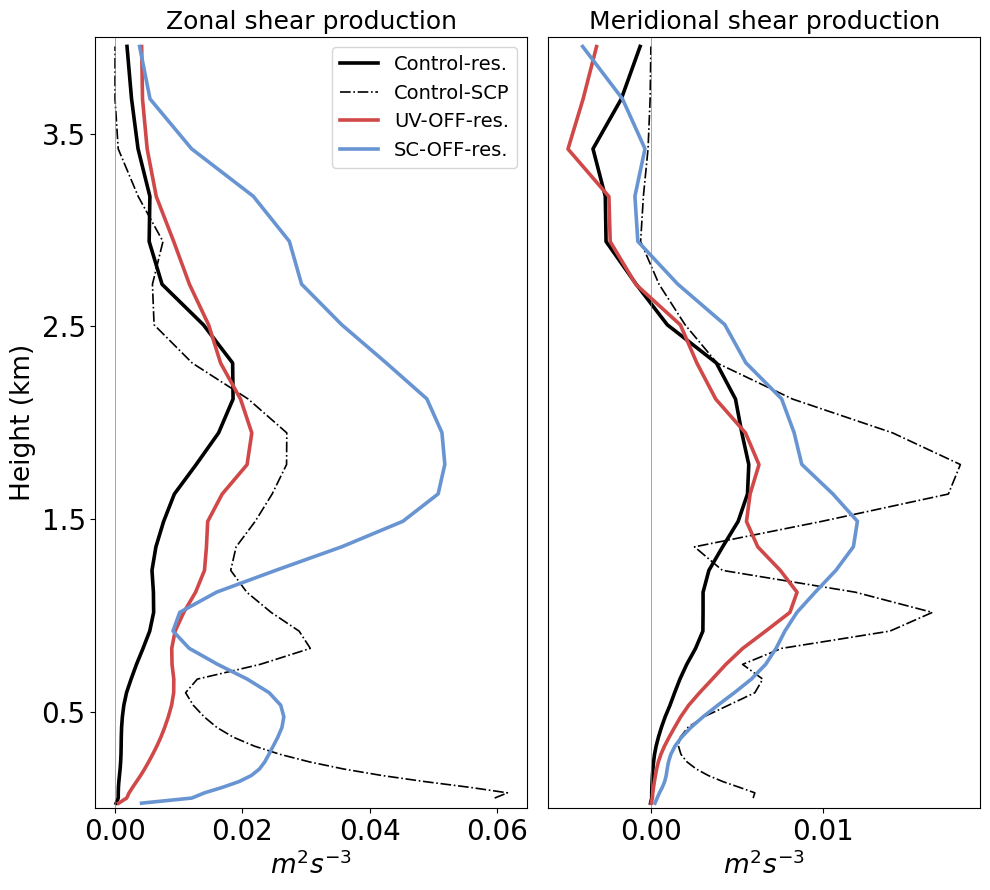

In [90]:
#%% Shear prouction term 
n_xplots = 2
n_yplots = 1
cmap_ = cm.coolwarm
sel_time = '2020'

fig, axs = plt.subplots(n_yplots,n_xplots,figsize=(10,9))
for idx, var in enumerate(['u','v']):
    for ide,exp in enumerate(exps):

        res_shear_prod = (-harm_subsamp[exp][var+'flx_resolved']*
                                harm2d[exp][var].differentiate('z')).sel(z=slice(0.01,4))
        turb_shear_prod= (-harm2d[exp][var+'flx_turb']*
                                harm2d[exp][var].differentiate('z')).sel(z=slice(0.04,4))
        tot_shear_prod = res_shear_prod + turb_shear_prod
        param_shear_prod = turb_shear_prod
        if exp ==exps[0]:
                conv_shear_prod = (-(harm2d[exp][var+'flx_conv_dry']+harm2d[exp][var+'flx_conv_moist'])*
                                       harm2d[exp][var].differentiate('z')).sel(z=slice(0.01,4))
                tot_shear_prod = res_shear_prod + turb_shear_prod + conv_shear_prod
                param_shear_prod = turb_shear_prod + conv_shear_prod

        ## resolved
        res_shear_prod.sel(time=sel_time).mean('time').plot(y='z',lw=2.6,ls='-',ax=axs[idx],c=col[ide],label=lab[ide]+'-res.')
        # parameterised (turbulent + convective)
        if exp == exps[0]:
            conv_shear_prod.sel(z=slice(0.05,4)).sel(time=sel_time).mean('time').plot(y='z',lw=1.2,ls='-.',ax=axs[idx],c=col[ide],label=lab[ide]+'-SCP')

    axs[idx].axvline(0,c='grey',lw=0.5)
    axs[idx].set_ylim((0,4)) 
    axs[idx].set_xlabel(r'$m^2 s^{-3}$',fontsize=19)
    
    ##
axs[0].set_ylabel('Height (km)',fontsize=19)
axs[0].set_yticks([0.5,1.5,2.5,3.5]) 
axs[1].set_yticks([]) 
axs[1].set_ylabel('')
axs[0].set_title('Zonal shear production',fontsize=18) 
axs[1].set_title('Meridional shear production',fontsize=18) 
axs[0].legend(fontsize=14)
plt.tight_layout()
plt.savefig(figure_dir+'shear_prod.pdf')

In [70]:
#%% Shear prouction term 
n_xplots = 2
n_yplots = 2
cmap_ = cm.coolwarm
sel_time = '2020'
para_res = 'conv'
# sel_time=harm2d[exp].time

fig, axs = plt.subplots(n_yplots,n_xplots,figsize=(10,13))
for idx, var in enumerate(['u','v']):
    for ide,exp in enumerate(exps):

        res_shear_prod = (-harm_subsamp[exp][var+'flx_resolved']*
                                harm2d[exp][var].differentiate('z')).sel(z=slice(0.01,4))
        turb_shear_prod= (-harm2d[exp][var+'flx_turb']*
                                harm2d[exp][var].differentiate('z')).sel(z=slice(0.04,4))
        tot_shear_prod = res_shear_prod + turb_shear_prod
        if exp ==exps[0]:
                conv_shear_prod = (-(harm2d[exp][var+'flx_conv_dry']+harm2d[exp][var+'flx_conv_moist'])*
                                       harm2d[exp][var].differentiate('z')).sel(z=slice(0.01,4))
                tot_shear_prod = res_shear_prod + turb_shear_prod + conv_shear_prod

        ## parameterised by SC
        if exp ==exps[0]:
            conv_shear_prod.sel(time=sel_time).mean('time').plot(y='z',lw=1.5,ls='-.',ax=axs[0,idx],c=col[ide],label=lab[ide]+'-SCP')
        ## parameterised by turb.
        # turb_shear_prod.sel(time=sel_time).mean('time').plot(y='z',lw=2,ls=':',ax=axs[0,idx],c=col[ide],label=lab[ide]+'-turb.')
        ## total
        # tot_shear_prod.sel(time=sel_time).mean('time').plot(y='z',lw=1.5,ls='-',ax=axs[1,idx],c=col[ide],label=lab[ide]+'-total')
        ## resolved
        res_shear_prod.sel(time=sel_time).mean('time').plot(y='z',lw=2,ls='-',ax=axs[1,idx],c=col[ide],label=lab[ide]+'-res.')

    axs[0,idx].axvline(0,c='grey',lw=0.5)
    axs[1,idx].axvline(0,c='grey',lw=0.5)
    axs[0,idx].set_ylim((0,4)) 
    axs[1,idx].set_ylim((0,4)) 
    axs[idx,0].set_ylabel('Height (km)',fontsize=19)
    axs[idx,0].set_yticks([0.5,1.5,2.5,3.5]) 
    axs[0,idx].set_xlabel('') 
    axs[idx,1].set_yticks([]) 
    axs[idx,1].set_ylabel('')
    axs[1,idx].set_xlabel(r'$m^2 s^{-3}$',fontsize=19)
    
    ##
# axs[0,0].set_xlim((-0.015,0.043))
# axs[1,0].set_xlim((-0.015,0.043))
# axs[0,1].set_xlim((-0.0064,0.01))
# axs[1,1].set_xlim((-0.0064,0.01))
axs[0,1].set_ylabel('')
axs[0,0].set_title('Zonal shear production',fontsize=18) 
axs[0,1].set_title('Meridional shear production',fontsize=18) 
axs[0,0].legend(fontsize=14)
axs[1,0].legend(fontsize=14)
plt.tight_layout()
# plt.savefig(figure_dir+'shear_prod.pdf')

### Appendix

##### Moisture Budget

/var/folders/s5/wykd_yfn5wb9597rr8n4crdxqqfkds/T/ipykernel_1550/816532635.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


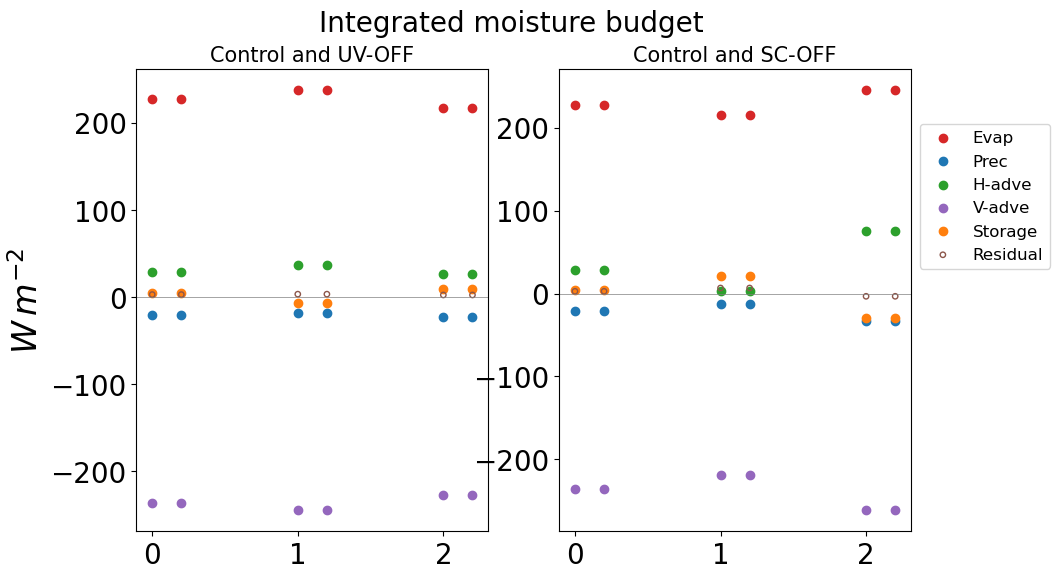

In [205]:
#%% moisture budget 
from matplotlib.colors import to_hex
# Create a ListedColormap with the specified colormap and number of colors
cmap = cm.get_cmap('tab10')
# Sample 10 colors from the colormap
colors = cmap.colors[:6]
to_hex(colors[1])
fig, axs = plt.subplots(1,2,figsize=(10,6))
handles = []  # To store handles for legend
labels = []   # To store labels for legend
for ide,exp in enumerate(exps):
    if exp != exps[2]:
        ide = ide * 0.2
        for idx, sel_time in enumerate(['2020',time_CC_exp_is_larger[exps[1]],time_CC_exp_is_smaller[exps[1]]]):
            handles.append(axs[0].scatter(idx+ide,moist_budg[exps[0]]['E_slab'].sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[3]),label='Evap'))
            handles.append(axs[0].scatter(idx+ide,-moist_budg[exps[0]]['P_slab'].sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[0]),label='Prec'))
            handles.append(axs[0].scatter(idx+ide,-(moist_budg[exps[0]]['U_adv_slab']+
                            moist_budg[exps[0]]['V_adv_slab']).sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[2]),label='H-adve'))
            handles.append(axs[0].scatter(idx+ide,-moist_budg[exps[0]]['W_adv_slab'].sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[4]),label='V-adve'))
            handles.append(axs[0].scatter(idx+ide,-moist_budg[exps[0]]['storage_slab'].sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[1]),label='Storage'))
            handles.append(axs[0].scatter(idx+ide,-moist_budg[exps[0]]['residual_slab'].sel(time=sel_time).mean('time').values
                            ,s=15,c='none', edgecolors=to_hex(colors[5]),label='Residual'))
    if exp != exps[1]:
        ide = ide * 0.1
        for idx, sel_time in enumerate(['2020',time_CC_exp_is_larger[exps[2]],time_CC_exp_is_smaller[exps[2]]]):
            handles.append(axs[1].scatter(idx+ide,moist_budg[exps[0]]['E_slab'].sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[3]),label='Evap'))
            handles.append(axs[1].scatter(idx+ide,-moist_budg[exps[0]]['P_slab'].sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[0]),label='Prec'))
            handles.append(axs[1].scatter(idx+ide,-(moist_budg[exps[0]]['U_adv_slab']+
                            moist_budg[exps[0]]['V_adv_slab']).sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[2]),label='H-adve'))
            handles.append(axs[1].scatter(idx+ide,-moist_budg[exps[0]]['W_adv_slab'].sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[4]),label='V-adve'))
            handles.append(axs[1].scatter(idx+ide,-moist_budg[exps[0]]['storage_slab'].sel(time=sel_time).mean('time').values
                            ,c=to_hex(colors[1]),label='Storage'))
            handles.append(axs[1].scatter(idx+ide,-moist_budg[exps[0]]['residual_slab'].sel(time=sel_time).mean('time').values
                            ,s=15,c='none', edgecolors=to_hex(colors[5]),label='Residual'))

labels = ['Evap', 'Prec', 'H-adve', 'V-adve', 'Storage', 'Residual']
axs[0].axhline(0,c='grey',lw=0.5)
axs[1].axhline(0,c='grey',lw=0.5)
axs[0].set_xticks([0,1,2]) 
axs[1].set_xticks([0,1,2]) 

axs[0].set_ylabel(r'$W \, m^{-2}$')
axs[1].set_ylabel(r'')
axs[0].set_title('Control and UV-OFF',fontsize=15)
axs[1].set_title('Control and SC-OFF',fontsize=15)
plt.suptitle('Integrated moisture budget',fontsize=20)
plt.legend(handles[:6], labels[:6],ncol=1,bbox_to_anchor=(1, 0.9))


### TKE

##### Add TKE profiles at 2.5 and 20 km resolution

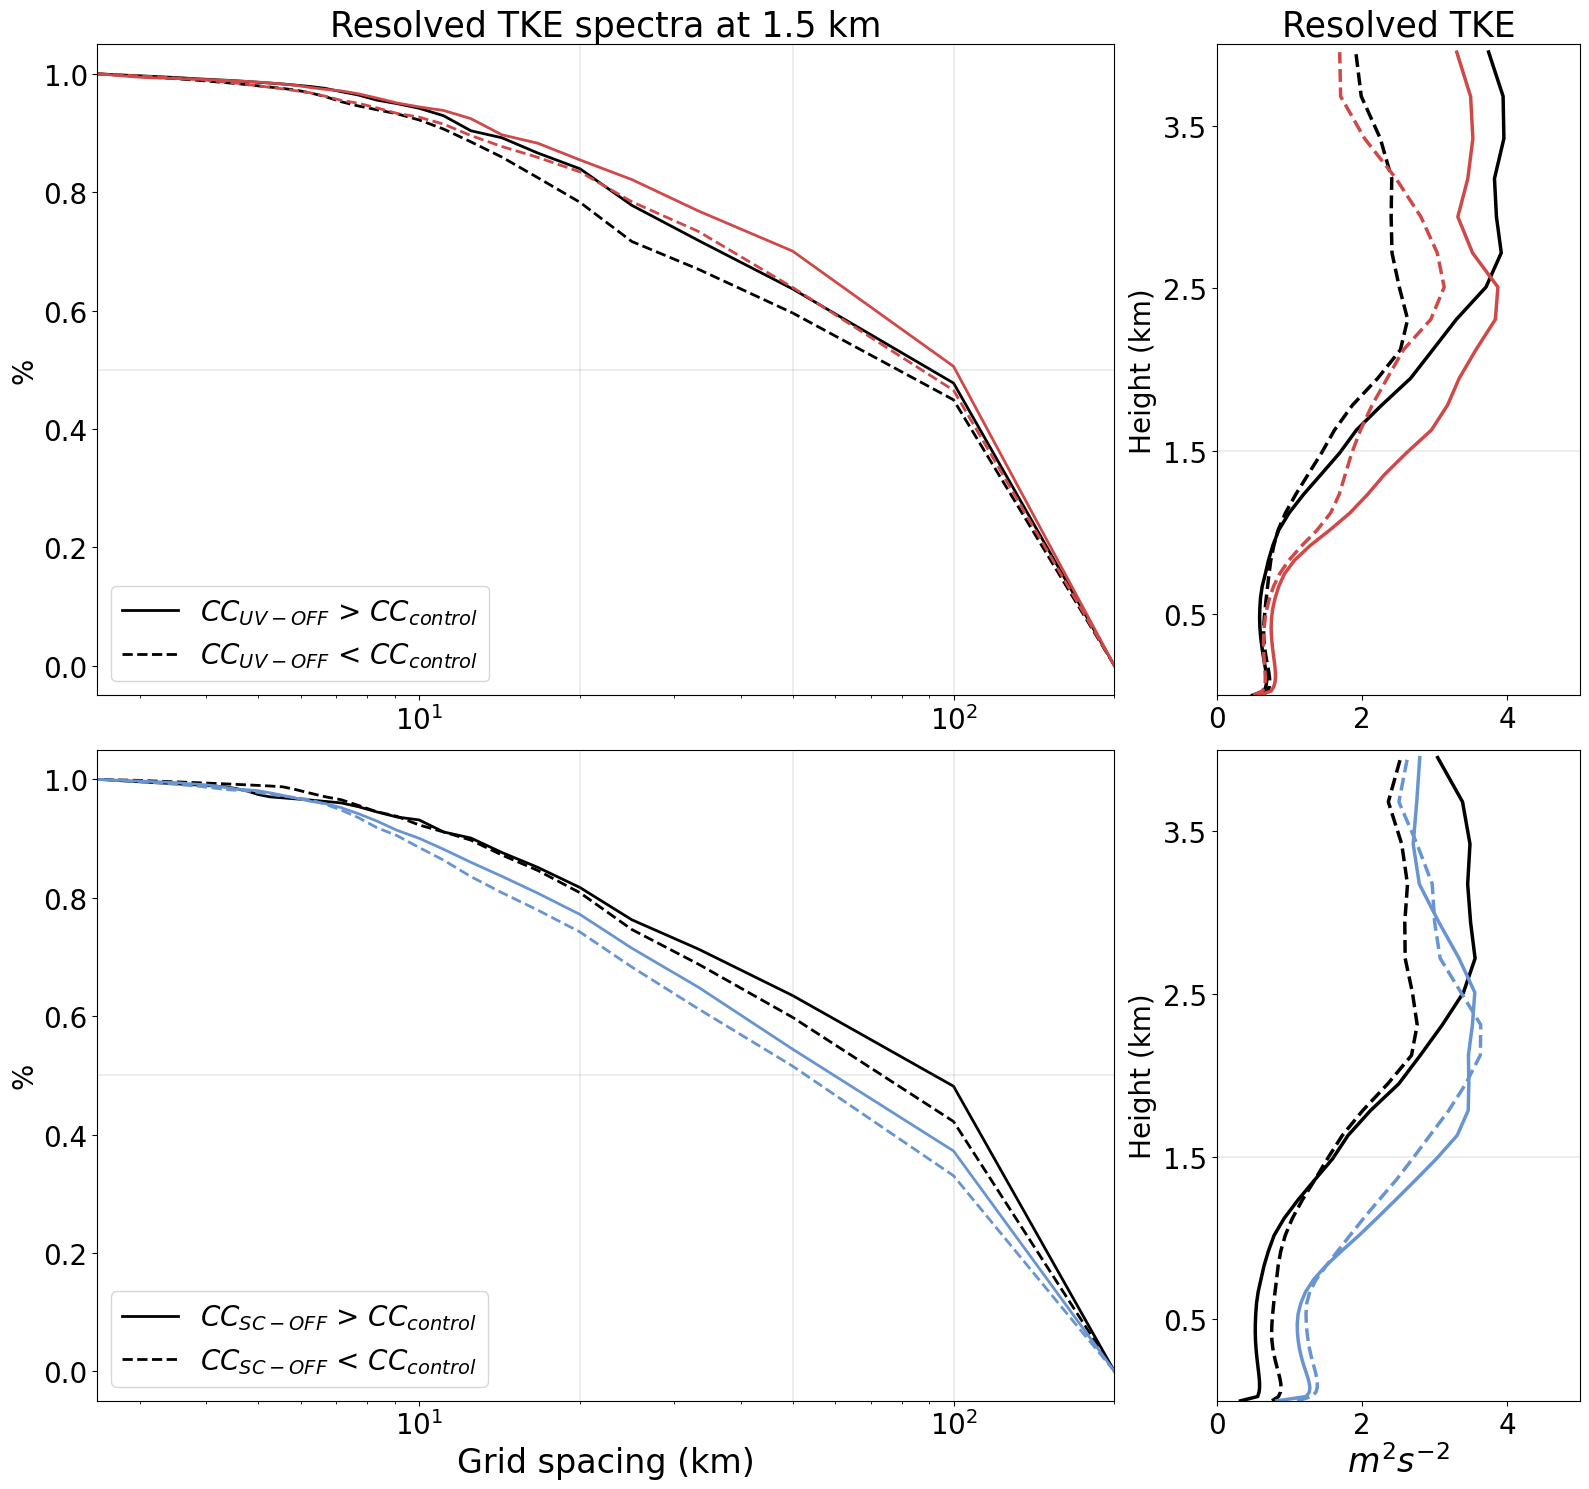

In [11]:
#%% Spectral and profile TKE
# available levels for spectra: 0.2, 0.6, 1, 1.12, 1.5
sel_time = '2020'
sel_z1 = 1.5 #m
# sel_z2 = 200 #m
fig, axs = plt.subplots(2,2,figsize=(16,15), gridspec_kw={'width_ratios': [2.8,1]})
for ide,exp in enumerate(exps):
    if exp != exps[2]:
        for idt, sel_time in enumerate([time_CC_exp_is_larger[exps[1]],time_CC_exp_is_smaller[exps[1]]]):
            data_temp1 = spectral[exp].sel(time=sel_time).sel(z=sel_z1,method='nearest')['tke']
            ### first the spectra
            axs[0,0].plot(spectral[exp]['grid_spacing'],
                     data_temp1.median('time')/data_temp1.median('time').max(),
                    c=col[ide],lw=2,ls=sty[idt],label=lab[ide])
            ### then the profiles
            data_temp2 = harm2d[exp]['tke'].sel(z=slice(0,4)).sel(time=sel_time).mean('time')
            data_temp2.plot(y='z',ax=axs[0,1],
                           color=col[ide],lw=2.5,ls=sty[idt],label=lab[ide])
            
    if exp != exps[1]:
        for idt, sel_time in enumerate([time_CC_exp_is_larger[exps[2]],time_CC_exp_is_smaller[exps[2]]]):
            data_temp1 = spectral[exp].sel(time=sel_time).sel(z=sel_z1,method='nearest')['tke']
            ### first the spectra
            axs[1,0].plot(spectral[exp]['grid_spacing'],
                     data_temp1.median('time')/data_temp1.median('time').max(),
                    c=col[ide],lw=2,ls=sty[idt],label=lab[ide])
            ### then the profiles
            data_temp2 = harm2d[exp]['tke'].sel(z=slice(0,4)).sel(time=sel_time).mean('time')
            data_temp2.plot(y='z',ax=axs[1,1],
                           color=col[ide],lw=2.5,ls=sty[idt],label=lab[ide])

for idy in [0,1]:
    axs[idy,0].axhline(0.5,c='grey',lw=0.2)
    axs[idy,0].axvline(20,c='grey',lw=0.2)
    axs[idy,0].axvline(50,c='grey',lw=0.2)
    axs[idy,0].axvline(100,c='grey',lw=0.2)
    axs[idy,1].axhline(sel_z1,c='grey',lw=0.2)
    axs[idy,0].set_xlim([2.5,200])
    axs[idy,0].set_ylabel(r'%',fontsize=20)
    axs[idy,1].set_ylim([0,4])
    axs[idy,1].set_xlim([0,5])
    axs[idy,1].set_yticks([0.5,1.5,2.5,3.5]) 
    axs[idy,1].set_ylabel(r'Height (km)',fontsize=20)
    axs[idy,0].set_xscale('log')
axs[1,0].set_xlabel('Grid spacing (km)')
axs[0,1].set_xlabel(r'')
axs[1,1].set_xlabel(r'$m^2 s^{-2}$')
axs[0,0].set_title('Resolved TKE spectra at '+str(sel_z1)+' km',
         fontsize=25)
axs[0,1].set_title('Resolved TKE',fontsize=25)
axs[1,1].set_title('')

axs[0, 0].legend([r'$CC_{'+lab[1]+'}$ > $CC_{control}}$',
                  '$CC_{'+lab[1]+'}$ < $CC_{control}}$'],
                    fontsize=20)
axs[1, 0].legend([r'$CC_{'+lab[2]+'}$ > $CC_{control}}$',
                  '$CC_{'+lab[2]+'}$ < $CC_{control}}$'],
                    fontsize=20)
plt.tight_layout()
# plt.savefig(figure_dir+'tke_spectra_and_profiles.pdf')

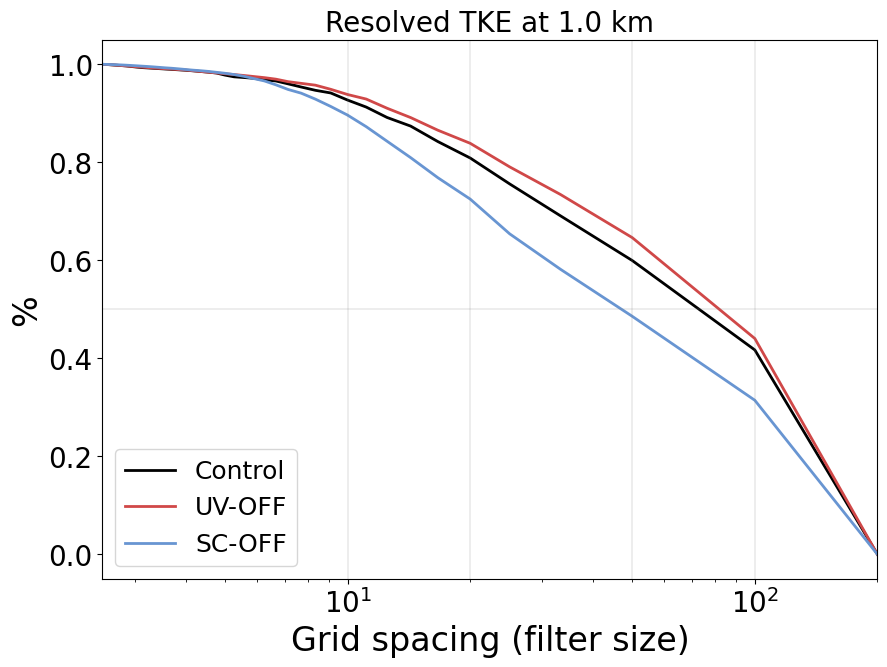

In [302]:
#%% Spectral TKE 
sel_time = '2020'
sel_z1 = 1000 #m
# sel_z2 = 200 #m
plt.figure()
for ide,exp in enumerate(exps):
    data_temp1 = spectral[exp].sel(time=sel_time).sel(z=sel_z1,method='nearest')['tke']
    data_temp2 = spectral[exp].sel(time=sel_time).sel(z=sel_z1,method='nearest')['tke']
    ###
    # plt.plot(spectral[exp]['grid_spacing'],
    #          data_temp1.mean('time')/data_temp1.mean('time').max(),
    #         c=col[ide],lw=2,ls=':',label=lab[ide])
    plt.plot(spectral[exp]['grid_spacing'],
             data_temp1.median('time')/data_temp1.median('time').max(),
            c=col[ide],lw=2,ls='-',label=lab[ide])
    ###
    # plt.plot(spectral[exp]['grid_spacing'],
    #          data_temp2.median('time')/data_temp2.median('time').max(),
    #         c=col[ide],lw=2,ls=':',label=lab[ide])
    ###
plt.title('Resolved TKE at '+str(sel_z1/1000)+' km',
         fontsize=20)
plt.xlabel('Grid spacing (filter size)')
plt.ylabel(r'%')
plt.xscale('log')
plt.axvline(10,c='grey',lw=0.2)
plt.axvline(20,c='grey',lw=0.2)
plt.axvline(50,c='grey',lw=0.2)
plt.axvline(100,c='grey',lw=0.2)
plt.axhline(0.5,c='grey',lw=0.2)
plt.xlim([2.5,200])
plt.legend(fontsize=18)
###################################
###################################


### Scatterplot with GOES16

In [213]:
from scipy.optimize import curve_fit

### Define function with paramiters to fit 
#########
# def func(x, a, c, d):
#     return a*np.exp(-c*x)+d

def func(x,a):
    return (1-x)**a

# def func(x,a,b):
#     return a*x +b

# def func(x,a,b,c):
#     return a*(x**2) +b*x +c

### Estimate parameters for GOES16 data 
#########
# popt, pcov = curve_fit(func, goes16_org['open_sky'].dropna('time'),
#                        goes16_org['cloud_fraction'].dropna('time'), p0=(1,1e-6,1))

popt, pcov = curve_fit(func,goes16_org['open_sky'].dropna('time'),
                       goes16_org['cloud_fraction'].dropna('time'),p0=1)

# a,b,c = np.polyfit(np.log10(goes16_org['open_sky'].dropna('time')),
#                  np.log10(goes16_org['cloud_fraction'].dropna('time')),2)

# a,b,c = np.polyfit(goes16_org['open_sky'].dropna('time'),
#                  goes16_org['cloud_fraction'].dropna('time'),2)

### Compute function 
xx = np.linspace(0.01, 1, 1000)
yy_goes = func(xx,*popt)

### Estimate parameters and compute function for HARMONIE
#########
yy_harm = {}
# for exp in exps:
#     # popt, pcov = curve_fit(func, ds_org_4km[exp]['open_sky'].dropna('time'),
#     #                        ds_org_4km[exp]['cloud_fraction'].dropna('time'), p0=(1,1e-6,1))

#     popt, pcov = curve_fit(func, ds_org_4km[exp]['open_sky'].dropna('time'),
#                            ds_org_4km[exp]['cloud_fraction'].dropna('time'),p0=1)

#     # a,b = np.polyfit(np.log10(ds_org_4km[exp]['open_sky'].dropna('time')),
#     #                  np.log10(ds_org_4km[exp]['cloud_fraction'].dropna('time')),2)
#     yy_harm[exp] = func(xx,*popt)


In [215]:
plt.figure()
plt.scatter(goes16_org.open_sky.dropna('time'),
            goes16_org.cloud_fraction.dropna('time'),
            c=col_obs[0],s=5,alpha=0.6,label='GOES16')
plt.plot(xx, yy_goes,c=col_obs[0])
# for ide,exp in enumerate(exps):
#     plt.scatter(ds_org_4km[exp].open_sky.dropna('time'),
#                 ds_org_4km[exp].cloud_fraction.dropna('time'),
#                 s=1,c=col[ide],alpha=0.4,label=lab[ide])
#     plt.plot(xx, yy_harm[exp],c=col[ide])

plt.xlabel('Open sky')
plt.ylabel('Cloud cover')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.legend(fontsize=15)

In [203]:
fig, axs = plt.subplots(2,2,figsize=(16,15))
for ide,exp in enumerate(exps):
    axs[1,1].scatter(goes16_org.open_sky,goes16_org.cloud_fraction,
                c=col_obs[0],s=2,alpha=0.6,label='GOES16')
    axs[1,1].plot(xx, yy_goes,lw=2,c=col_obs[0])
    axs[1,1].plot(xx, yy_harm[exp],lw=2,c=col[ide])
    axs[1,1].set_xlim([0,1])
    axs[1,1].set_ylim([0,1])
    axs[1,1].set_title('GOES16',fontsize=18)
for ide,exp in enumerate(exps):
    ## scatter plot
    # if exp != exps[0]:
    #     ## CC> control
    #     axs[ide//2,ide%2].scatter(ds_org_4km[exp].sel(time=time_CC_exp_is_larger[exp]).open_sky,
    #                               ds_org_4km[exp].sel(time=time_CC_exp_is_larger[exp]).cloud_fraction,
    #                 s=2,c=col[ide],alpha=0.6,label=lab[ide])
    #     ## CC< control
    #     axs[ide//2,ide%2].scatter(ds_org_4km[exp].sel(time=time_CC_exp_is_smaller[exp]).open_sky,
    #                               ds_org_4km[exp].sel(time=time_CC_exp_is_smaller[exp]).cloud_fraction,
    #                 s=20,edgecolors=col[ide],facecolors='none',alpha=0.6,label=lab[ide])
    # else:
    axs[ide//2,ide%2].scatter(ds_org_4km[exp].open_sky,
                      ds_org_4km[exp].cloud_fraction,
        s=2,c=col[ide],alpha=0.6,label=lab[ide])
    
    ## fitted line
    axs[ide//2,ide%2].plot(xx, yy_harm[exp],lw=2,c=col[ide])
    axs[ide//2,ide%2].plot(xx, yy_goes,lw=2,c=col_obs[0])
    ## mean on X    
    axs[ide//2,ide%2].plot(ds_org_4km[exp].open_sky.mean(),0,
                marker='s',markersize=15,linestyle='None',mfc='none', color=col[ide])
    ## mean on Y    
    axs[ide//2,ide%2].plot(0,ds_org_4km[exp].cloud_fraction.mean(),
                marker='s',markersize=15,linestyle='None',mfc='none', color=col[ide])

    
    axs[ide//2,ide%2].set_xlim([0,1])
    axs[ide//2,ide%2].set_ylim([0,1])
    axs[ide//2,ide%2].set_title(lab[ide],fontsize=18)

axs[1,0].set_xlabel('Open sky')
axs[1,1].set_xlabel('Open sky')
axs[0,0].set_ylabel('Cloud cover')
axs[1,0].set_ylabel('Cloud cover')


Text(0, 0.5, 'Cloud cover')